# Описание проекта 

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

В данном отчете будет представлено решение двух задач: 
1. Построить модель, которая сможет предсказать уровень удовлетворенности сотрудника на основе данных заказчика. 
2. Построить модель, которое сможет предсказать увольнение сотрудника из компании. 

**Описание данных**

1. Данные предоставленного датасета:

- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

# Задача 1:  предсказание уровня удовлетворённости сотрудника

# Ознакомление и выгрузка данных 

In [1]:
# Необходимые импорты и настройки
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import phik

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_percentage_error, make_scorer, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC

# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

In [2]:
# Чтение данных  
train_sample = pd.read_csv('C://Users//79952/Desktop/Datasets/datasets_HR_analytics/train_job_satisfaction_rate.csv')     
test_features = pd.read_csv('C://Users//79952/Desktop/Datasets/datasets_HR_analytics/test_features.csv')     
test_target = pd.read_csv('C://Users//79952/Desktop/Datasets/datasets_HR_analytics/test_target_job_satisfaction_rate.csv')

In [3]:
# Вывод данных

datasets = {'train_sample': train_sample, 
           'test_features': test_features, 
           'test_target': test_target}

for dataset_name, dataset in datasets.items(): 
    print('\n', '-'*40, f'Общая информация датасета {dataset_name}', '-'*40, '\n')
    dataset.info()
    print('\n', '-'*40, f'Содержание датасета {dataset_name}', '-'*40)
    display(dataset.head())


 ---------------------------------------- Общая информация датасета train_sample ---------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB

 ---------------------------------------- Содержание датасета train_sample ----

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20



 ---------------------------------------- Общая информация датасета test_features ---------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB

 ---------------------------------------- Содержание датасета test_features ----------------------------------------


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



 ---------------------------------------- Общая информация датасета test_target ---------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB

 ---------------------------------------- Содержание датасета test_target ----------------------------------------


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


# Предобработка данных 

Выведем уникальные значения категориальных данных, чтобы увидеть нужна ли корректировка значений

## Изменение значений 

In [4]:
col_category = ['dept', 
                'level', 
                'workload', 
                'last_year_promo', 
                'last_year_violations']

for col in col_category: 
    print(f'\n Уникальные значения датасета train_sample, столбец {col}: ')
    print(train_sample[col].unique())
    
for col in col_category: 
    print(f'\n Уникальные значения датасета test_features, столбец {col}: ')
    print(test_features[col].unique())


 Уникальные значения датасета train_sample, столбец dept: 
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]

 Уникальные значения датасета train_sample, столбец level: 
['junior' 'middle' 'sinior' nan]

 Уникальные значения датасета train_sample, столбец workload: 
['medium' 'high' 'low']

 Уникальные значения датасета train_sample, столбец last_year_promo: 
['no' 'yes']

 Уникальные значения датасета train_sample, столбец last_year_violations: 
['no' 'yes']

 Уникальные значения датасета test_features, столбец dept: 
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']

 Уникальные значения датасета test_features, столбец level: 
['junior' 'middle' 'sinior' nan]

 Уникальные значения датасета test_features, столбец workload: 
['medium' 'low' 'high' ' ']

 Уникальные значения датасета test_features, столбец last_year_promo: 
['no' 'yes']

 Уникальные значения датасета test_features, столбец last_year_violations: 
['no' 'yes']


В датасете `test_features` вместо значений встречаются пробелы. Рассмотрим эту ситуацию

In [5]:
test_features[test_features['dept'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


In [6]:
test_features[test_features['workload'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


Всего две строки погоды не сделают. Заменим строки с пропущенными значениями на NAN

In [7]:
test_features['dept'] = test_features['dept'].replace(r'^\s*$', np.nan, regex=True)
test_features['workload'] = test_features['workload'].replace(r'^\s*$', np.nan, regex=True)

In [8]:
test_features[test_features.isna().any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,NaN,4,no,no,4,28800
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800
1699,822186,NaN,middle,medium,3,no,no,4,38400


In [9]:
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [10]:
test_features['workload'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

Пробелы успешно заменены на NAN. В данных также допущена грамматическая ошибка `sinior` (в обоих датасетах). Исправим это

In [11]:
train_sample['level'] = train_sample['level'].replace('sinior', 'senior')

print('Уникальные значения столбца level датасета train_sample:')
train_sample['level'].unique()

Уникальные значения столбца level датасета train_sample:


array(['junior', 'middle', 'senior', nan], dtype=object)

In [12]:
test_features['level'] = test_features['level'].replace('sinior', 'senior')

print('Уникальные значения столбца level датасета test_features:')
test_features['level'].unique()

Уникальные значения столбца level датасета test_features:


array(['junior', 'middle', 'senior', nan], dtype=object)

Теперь значения данных в порядке

Типы данных изменять не нужно 

## Пропуски и дубликаты

In [13]:
for dataset_name, dataset in datasets.items(): 
    print('\n','-'*10, f'Пропуски в датасете {dataset_name}', '-'*10, '\n')
    print(dataset.isna().sum())
    print(f'\n Количество дубликатов в датасете {dataset_name}: {dataset.duplicated().sum()}')


 ---------- Пропуски в датасете train_sample ---------- 

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

 Количество дубликатов в датасете train_sample: 0

 ---------- Пропуски в датасете test_features ---------- 

id                       0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

 Количество дубликатов в датасете test_features: 0

 ---------- Пропуски в датасете test_target ---------- 

id                       0
job_satisfaction_rate    0
dtype: int64

 Количество дубликатов в датасете test_target: 0


Обнаружены пропуски в датасетах `train_sample` и `test_features`. Избавимся от них на этапе создания пайплайна

# Исследовательский анализ данных

Проведем исследовательский анализ данных. Данные в тренировочной и тестовой выборке совпадают, поэтому будем проверять два признака за раз из этих двух датасетов

## Количественные признаки 

### `employment_years`

In [14]:
def do_EDA(dataset: list, 
           feature: str, 
           bins: int = 30, 
           kde: bool = True):
    
    print('Описательная статистика: ' + feature)
    display(dataset[feature].describe())
    
    sns.histplot(data=dataset, x=feature, bins=bins, kde=kde)
    plt.title('Гистограмма признака: ' + feature)
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.show()

    sns.boxplot(data=dataset, y=feature)
    plt.title('Боксплот признака: ' + feature)
    plt.show()

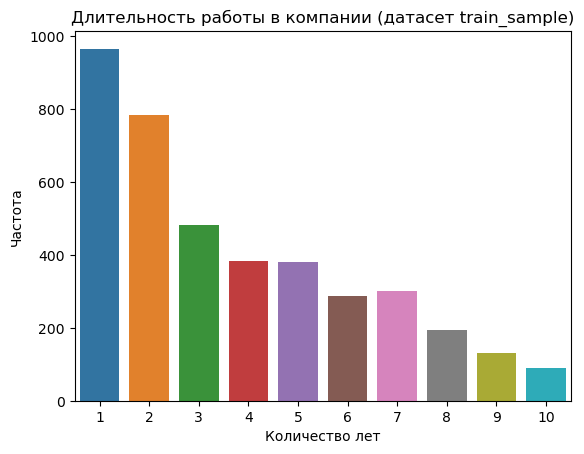

In [15]:
sns.countplot(data=train_sample, 
             x='employment_years')
plt.title('Длительность работы в компании (датасет train_sample)')
plt.xlabel('Количество лет')
plt.ylabel('Частота')
plt.show()

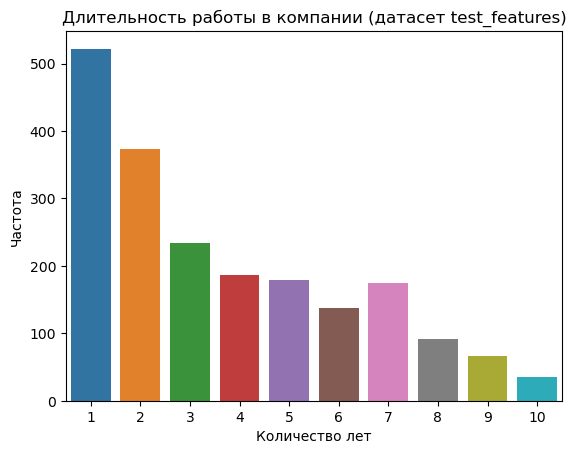

In [16]:
sns.countplot(data=test_features, 
             x='employment_years')
plt.title('Длительность работы в компании (датасет test_features)')
plt.xlabel('Количество лет')
plt.ylabel('Частота')
plt.show()

In [17]:
print('-'*25, 'Датасет train_sample', '-'*25, '\n')
print(train_sample['employment_years'].value_counts())

print('\n', '-'*25, 'Датасет test_features', '-'*25, '\n')
print(test_features['employment_years'].value_counts())

------------------------- Датасет train_sample ------------------------- 

employment_years
1     966
2     785
3     483
4     384
5     380
7     301
6     287
8     193
9     130
10     91
Name: count, dtype: int64

 ------------------------- Датасет test_features ------------------------- 

employment_years
1     522
2     374
3     234
4     187
5     179
7     174
6     138
8      91
9      66
10     35
Name: count, dtype: int64


Распределения данного признака в двух датасетах схожи (среднее, медиана и межквартильный размах). Признак имеет дискретные значения. В компании больше всего сотрудников, проработавших всего 1 год

### `supervisor_evaluation`

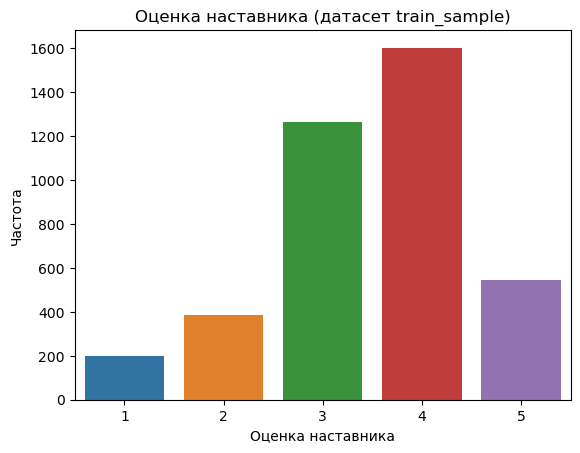

In [18]:
sns.countplot(data=train_sample, 
             x='supervisor_evaluation')
plt.title('Оценка наставника (датасет train_sample)')
plt.xlabel('Оценка наставника')
plt.ylabel('Частота')
plt.show()

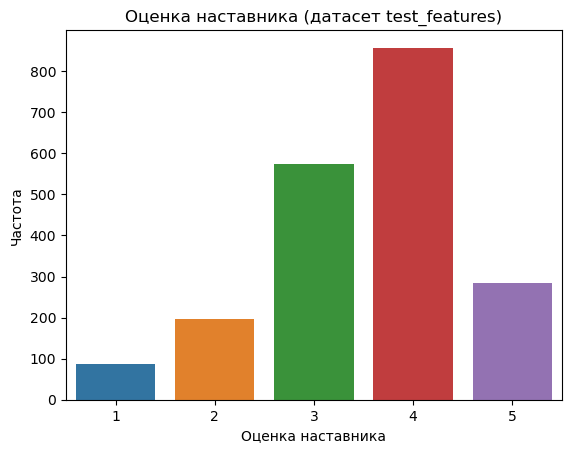

In [19]:
sns.countplot(data=test_features, 
             x='supervisor_evaluation')
plt.title('Оценка наставника (датасет test_features)')
plt.xlabel('Оценка наставника')
plt.ylabel('Частота')
plt.show()

In [20]:
print('-'*25, 'Датасет train_sample', '-'*25, '\n')
print(train_sample['supervisor_evaluation'].value_counts())

print('\n', '-'*25, 'Датасет test_features', '-'*25, '\n')
print(test_features['supervisor_evaluation'].value_counts())

------------------------- Датасет train_sample ------------------------- 

supervisor_evaluation
4    1603
3    1263
5     546
2     387
1     201
Name: count, dtype: int64

 ------------------------- Датасет test_features ------------------------- 

supervisor_evaluation
4    857
3    575
5    284
2    196
1     88
Name: count, dtype: int64


Распределения данного признака в двух датасетах схожи (среднее, медиана и межквартильный размах). Признак имеет дискретные значения. В компании больше всего сотрудников, имеющих оценку от ментора 4. Боксплот показывает выбросы, однако они не являются аномальными значениями, поэтому не будем от них избавлятся

### `salary`

------------------------- Датасет train_sample ------------------------- 

Описательная статистика: salary


count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

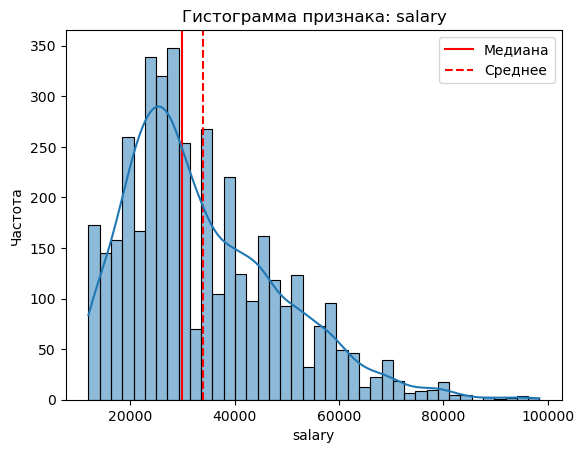

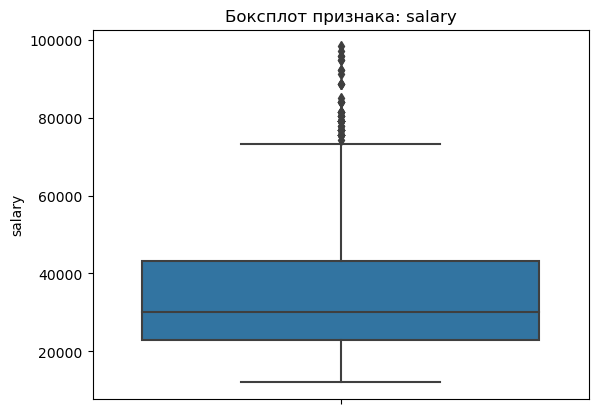


 ------------------------- Датасет test_features ------------------------- 

Описательная статистика: salary


count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

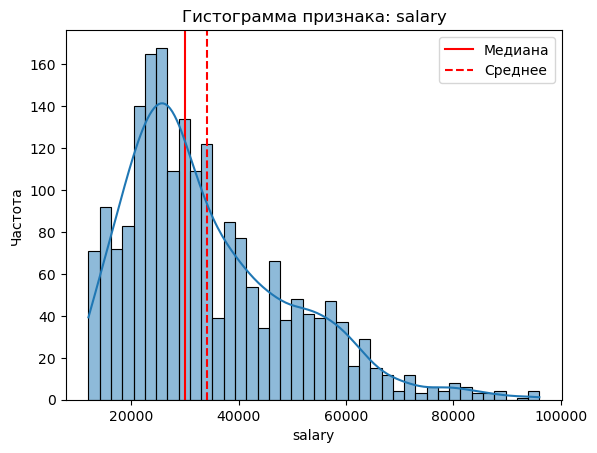

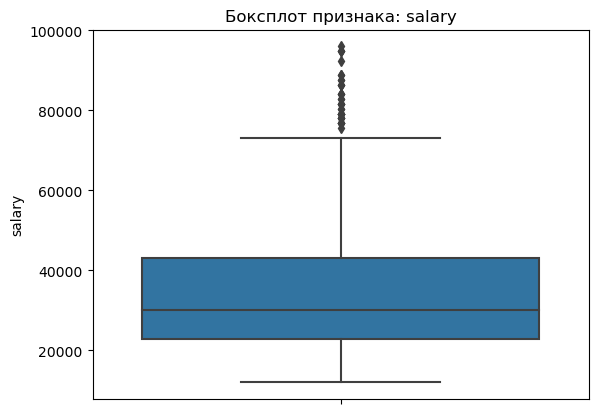

In [21]:
print('-'*25, 'Датасет train_sample', '-'*25, '\n')

plt.axvline(x=train_sample['salary'].median(), 
            c='red', 
            label='Медиана')

plt.axvline(x=train_sample['salary'].mean(), 
            c='red', 
            linestyle='dashed', 
            label='Среднее')
plt.legend()

do_EDA(dataset=train_sample, feature='salary', bins=40)

print('\n', '-'*25, 'Датасет test_features', '-'*25, '\n')

plt.axvline(x=test_features['salary'].median(), 
            c='red', 
            label='Медиана')

plt.axvline(x=test_features['salary'].mean(), 
            c='red', 
            linestyle='dashed', 
            label='Среднее')
plt.legend()

do_EDA(dataset=test_features, feature='salary', bins=40)

Распределения данного признака в двух датасетах схожи (среднее, медиана и межквартильный размах). Распределене похоже на Пуассоновское. Среднее и медиана не совпадают. Боксплот показывает выбросы, однако данные точки указывают на малочисленную группу, в которой находятся сотрудники с топ зарплатой. Не будем от них избавлятся 

### `job_satisfaction_rate`

In [22]:
train_sample.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


------------------------- Датасет train_sample ------------------------- 

Описательная статистика: job_satisfaction_rate


count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

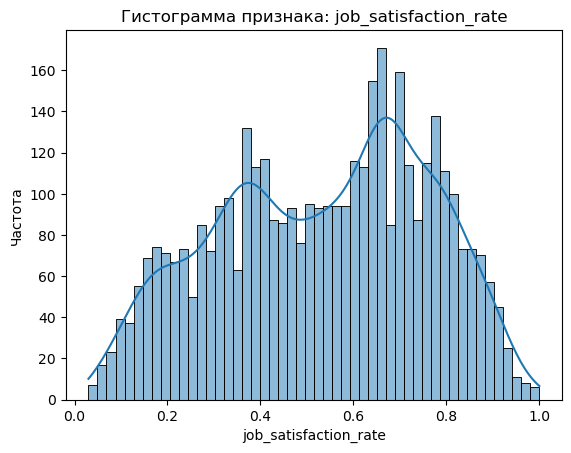

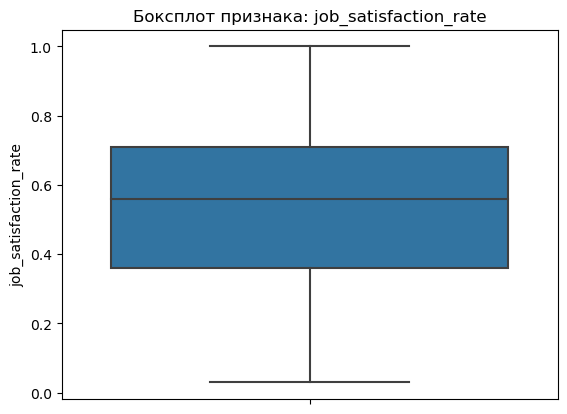


 ------------------------- Датасет test_features ------------------------- 

Описательная статистика: job_satisfaction_rate


count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

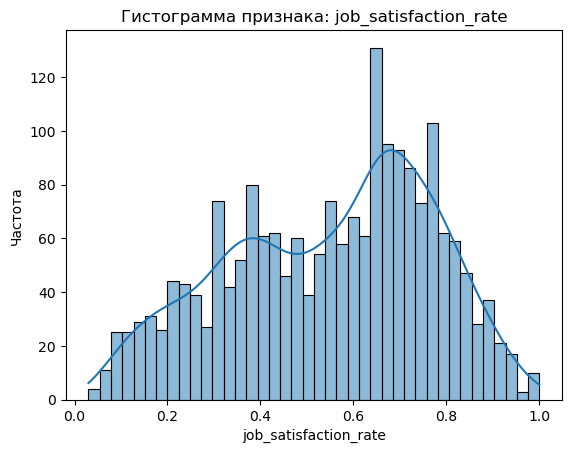

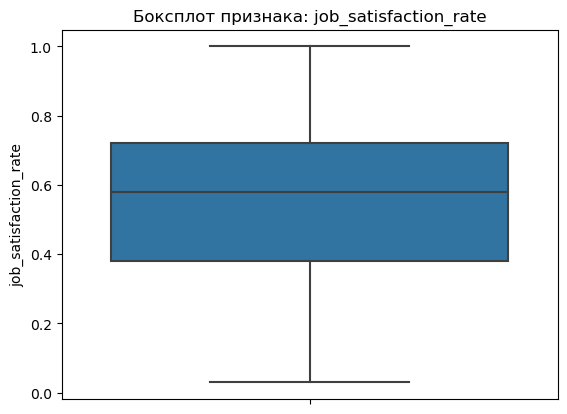

In [23]:
print('-'*25, 'Датасет train_sample', '-'*25, '\n')
do_EDA(dataset=train_sample, feature='job_satisfaction_rate', bins=50)

print('\n', '-'*25, 'Датасет test_features', '-'*25, '\n')
do_EDA(dataset=test_target, feature='job_satisfaction_rate', bins=40)

Распределения в датасетах схожи. Тип распределения напоминает бимодальное

## Категориальные признаки

### Датасет `train_sample`

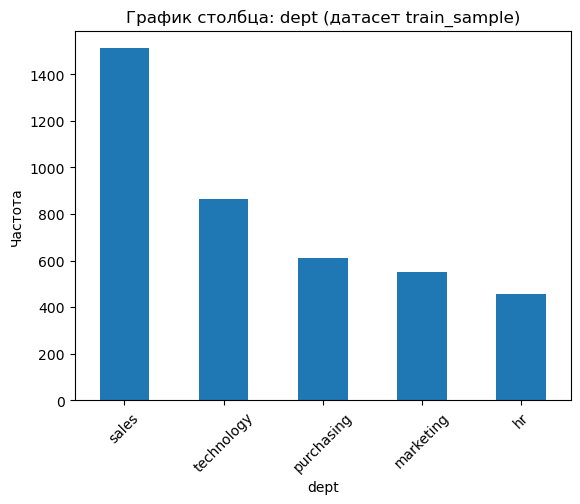

dept
sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: count, dtype: int64


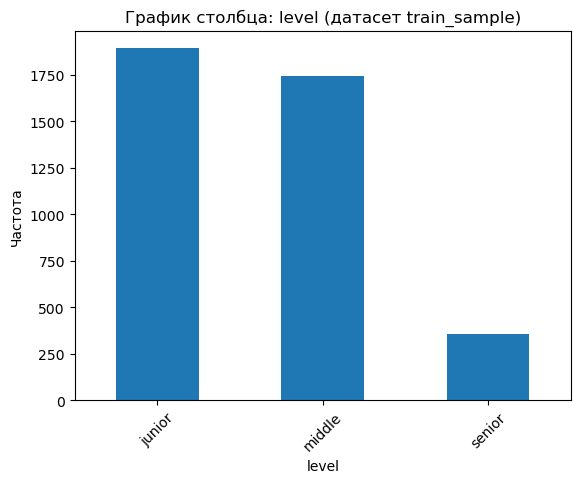

level
junior    1894
middle    1744
senior     358
Name: count, dtype: int64


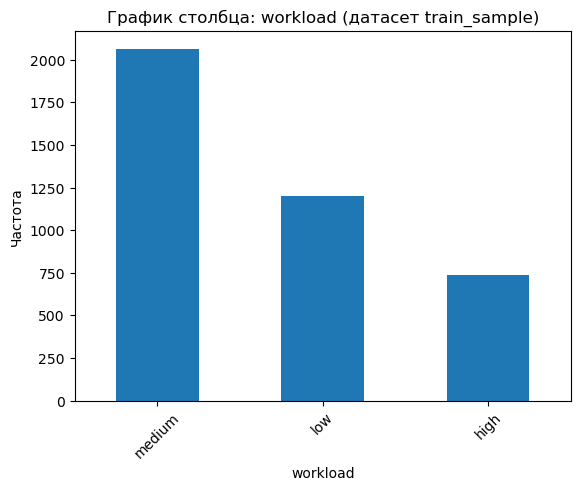

workload
medium    2066
low       1200
high       734
Name: count, dtype: int64


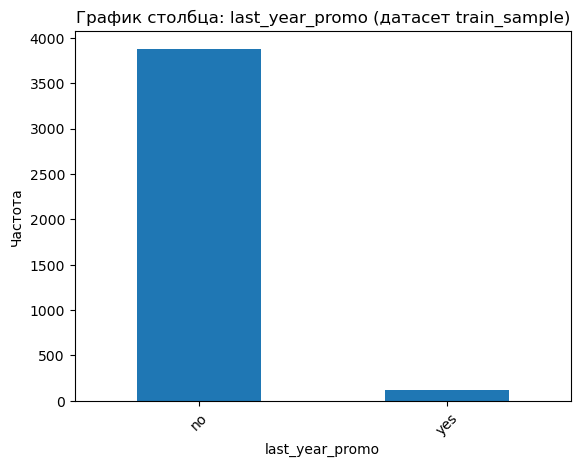

last_year_promo
no     3880
yes     120
Name: count, dtype: int64


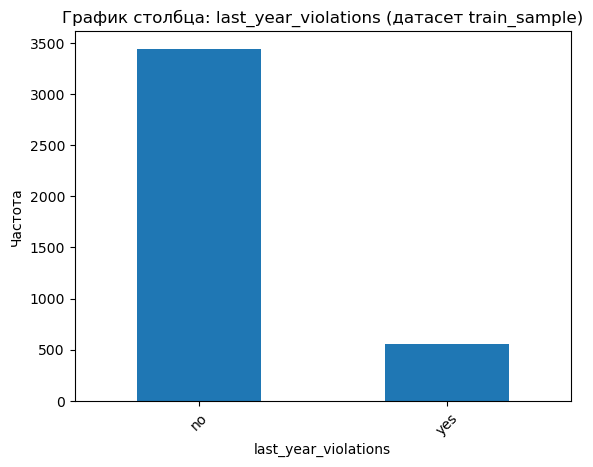

last_year_violations
no     3441
yes     559
Name: count, dtype: int64


In [24]:
for col in col_category: 
    train_sample[col].value_counts().plot.bar()
    plt.title('График столбца: ' + col + ' (датасет train_sample)')
    plt.ylabel('Частота')
    plt.xticks(rotation=45)
    plt.show()
    
    print(train_sample[col].value_counts())

### Датасет `test_features` 

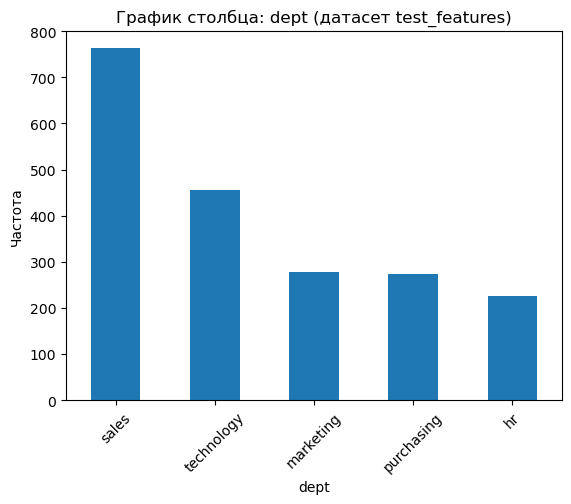

dept
sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: count, dtype: int64


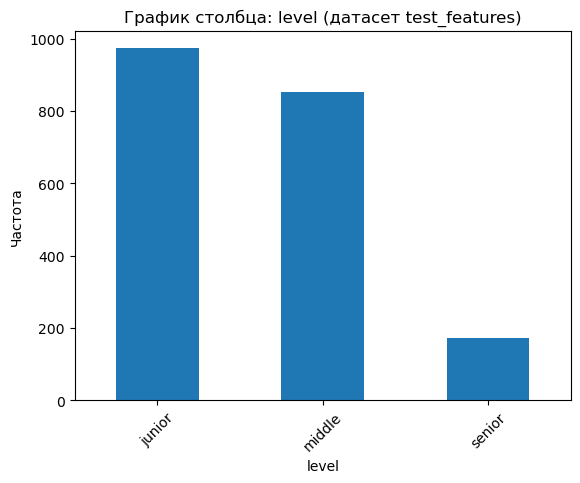

level
junior    1894
middle    1744
senior     358
Name: count, dtype: int64


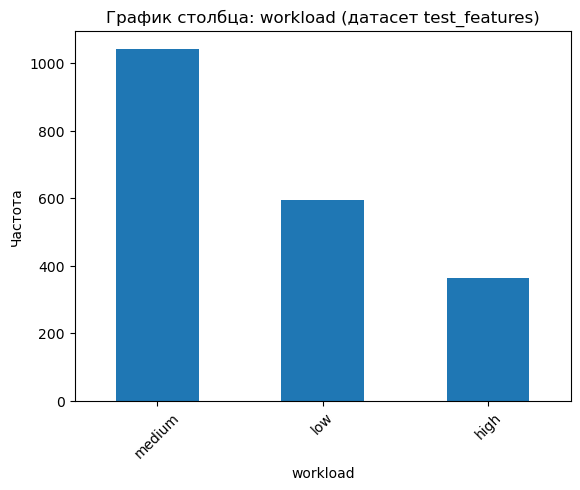

workload
medium    2066
low       1200
high       734
Name: count, dtype: int64


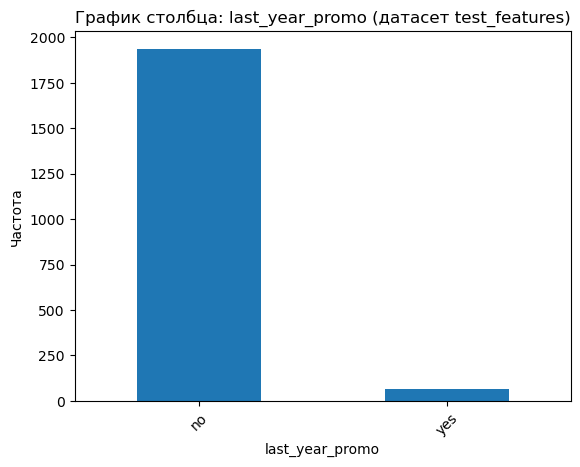

last_year_promo
no     3880
yes     120
Name: count, dtype: int64


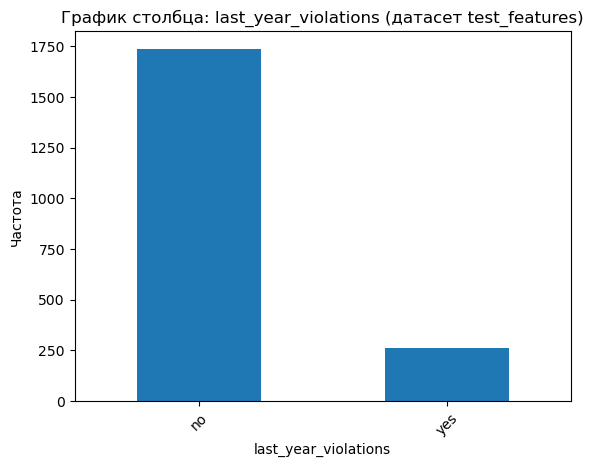

last_year_violations
no     3441
yes     559
Name: count, dtype: int64


In [25]:
for col in col_category: 
    
    test_features[col].value_counts().plot.bar()
    plt.title('График столбца: ' + col + ' (датасет test_features)')
    plt.ylabel('Частота')
    plt.xticks(rotation=45)
    plt.show()
    
    print(train_sample[col].value_counts())

Распределения в двух датасетах совпадают. Больше всего сотрудников работает в продажах, джунов и мидлов примерно одинаковое количество, синьоров намного меньше. Большинство сотрудников загружены по среднему уровню, также за последний год большинство сотрудников не имело повышения по работе и не нарушало трудовой договор

# Корреляционный анализ 

Проведем корреляционный анализ данных выборок

In [26]:
data_corr = train_sample.drop('id', axis=1)

corr_matrix = data_corr.phik_matrix(interval_cols = [
                                                     'salary', 
                                                     'job_satisfaction_rate', 
                                                     ])

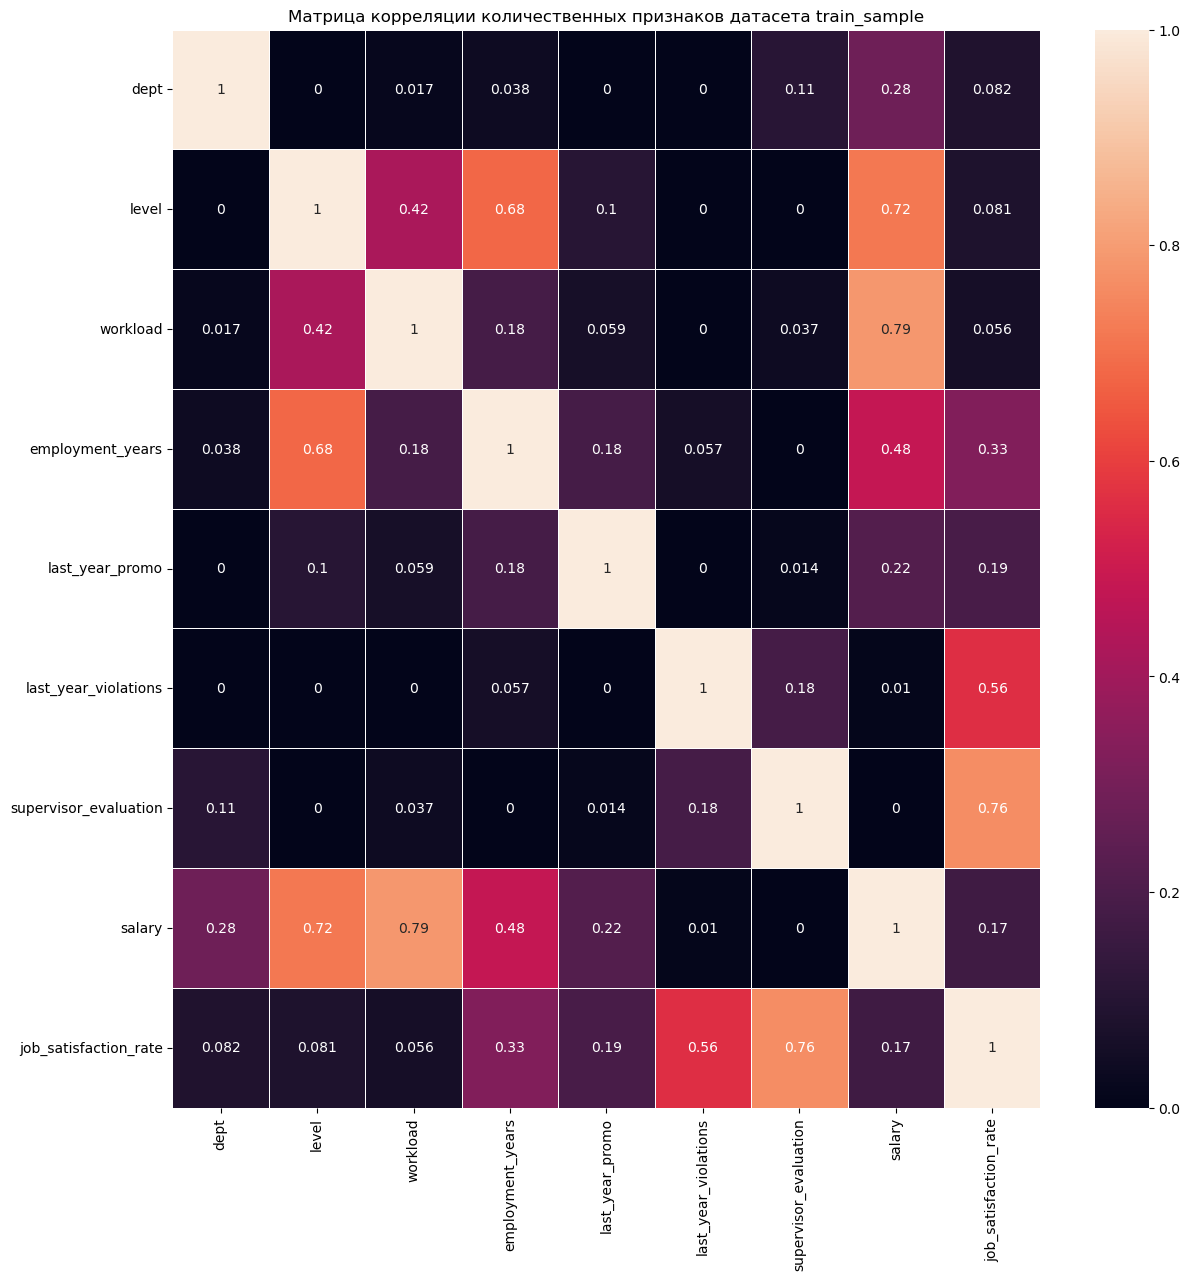

In [27]:
plt.figure(figsize= (14,14))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5)
plt.title('Матрица корреляции количественных признаков датасета train_sample')
plt.show()

In [28]:
data_for_corr = test_features.merge(test_target, on='id', how='left')
data_for_corr.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


In [29]:
data_for_corr.shape 

(2000, 10)

In [30]:
data_corr = data_for_corr.drop('id', axis=1)

corr_matrix = data_corr.phik_matrix(interval_cols = [
                                                     'salary', 
                                                     'job_satisfaction_rate', 
                                                     ])

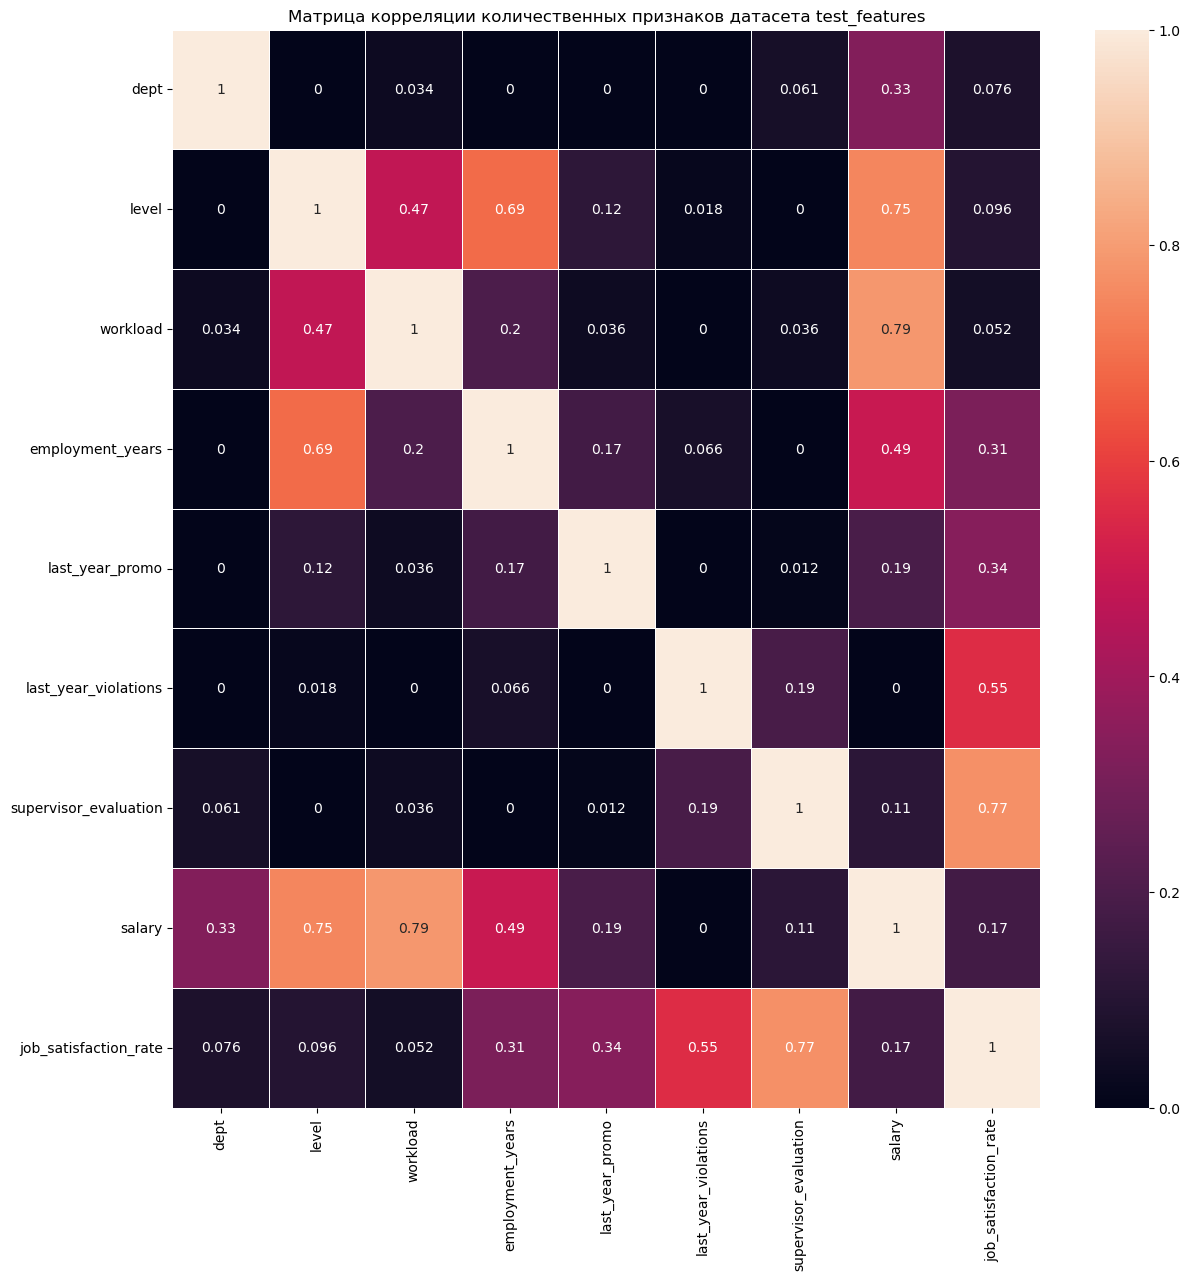

In [31]:
plt.figure(figsize= (14,14))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5)
plt.title('Матрица корреляции количественных признаков датасета test_features')
plt.show()

**Вывод**: Сильной линейной взаимосвязи между признаками не наблюдается. Мультиколлинеарности нет. 

# Подготовка данных 

Создадим тренировочные и тестовые выборки

In [32]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [33]:
test_target.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


ID сотрдуников в датасетах test_target и test_features расположены в разном порядке. Объединим их, чтобы устранить это несоответствие

In [34]:
test_sample = test_features.merge(test_target, on='id', how='left')
test_sample.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


Проверим наличие явных дубликатов после удаления столбца `id` тренировочной выборки, так как наличие явных дубликатов может помешать обучению модели. 

In [35]:
train_sample.drop('id', axis=1).duplicated().sum()

245

В тренировочной выборке появилось довольно много дубликатов после удаления столбца `id`. От них необходимо избавится

In [36]:
train_sample = train_sample.drop('id', axis=1).drop_duplicates()

In [37]:
train_sample.duplicated().sum()

0

Явные дубликаты в тренировочной выборке успешно удалены

In [38]:
X_train = train_sample.drop('job_satisfaction_rate', axis=1)
y_train = train_sample['job_satisfaction_rate']
X_test = test_sample.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = test_sample['job_satisfaction_rate']

Сэмплирование успешно проведено

Составим пайплайн подготовки данных

In [39]:
# Столбцы для кодировщиков
ohe_cols = ['dept']

ord_cols = ['level', 
            'workload', 
            'last_year_promo', 
            'last_year_violations']

num_cols = ['employment_years', 
            'supervisor_evaluation', 
            'salary']

In [40]:
# Категориальные кодировщики
# Пайплайн OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

# Пайплайн OrdinalEncoder
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'], 
                    ['no', 'yes'], 
                    ['no', 'yes']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# Сборка пайплайна обработки данных
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_cols), 
    ('ord', ord_pipe, ord_cols), 
    ('num', StandardScaler(), num_cols)
], 
    remainder='passthrough')

In [41]:
data_preprocessor.fit_transform(X_train)

array([[ 0.        ,  0.        ,  1.        , ..., -0.71067077,
        -2.4009163 , -0.69490778],
       [ 0.        ,  0.        ,  0.        , ..., -0.71067077,
         1.49723123,  0.26198934],
       [ 0.        ,  0.        ,  1.        , ..., -1.10178447,
        -1.42637942, -1.49232205],
       ...,
       [ 0.        ,  0.        ,  1.        , ...,  1.24489771,
         1.49723123, -0.69490778],
       [ 0.        ,  0.        ,  1.        , ..., -0.71067077,
        -0.45184253, -0.69490778],
       [ 0.        ,  0.        ,  0.        , ...,  0.46267032,
        -2.4009163 ,  0.66069648]])

In [42]:
RANDOM_STATE = 1

# Сборка финального пайплайна
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor), 
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

# Обучение моделей 

Обучим две модели, а потом оптимизируем их гиперпараметры

In [43]:
# Подбор скейлеров и моделей
param_grid = [
    {
    'models' : [DecisionTreeRegressor(splitter='best', random_state=RANDOM_STATE)],
    'models__max_depth': (range(6, 11)),
    'models__min_samples_leaf': (range(3, 6)),
    'models__min_samples_split': (range(2, 9)), 
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), "passthrough"],    
    },
    {
     'models' : [LinearRegression()], 
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), "passthrough"],
    },   
]

In [44]:
# Новая метрика
def custom_meric(y_true, y_pred): 
    error = np.abs(y_true - y_pred)
    scale = (np.abs(y_true) + np.abs(y_pred)) / 2
    return abs(np.mean(error / scale) * 100)

In [45]:
# Проверка на работу метрики
list_1 = np.arange(1, 10, 0.1)
list_2 = np.arange(1, 10, 0.1)
custom_meric(list_1, list_2)

0.0

In [46]:
SMAPE_scorer = make_scorer(custom_meric, 
                          greater_is_better=False)

In [47]:
# Запуск перебора скейлеров и моделей
grid = GridSearchCV(
        pipe_final, 
        param_grid=param_grid, 
        cv=5, 
        scoring= SMAPE_scorer, 
        n_jobs=-1)

In [48]:
grid.fit(X_train, y_train)
print('Лучшая модель и ее параметры:\n \n', grid.best_estimator_)

Лучшая модель и ее параметры:
 
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                          

В результате получается модель со следующими наилучшими показателями: 


In [49]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__max_depth,param_models__min_samples_leaf,param_models__min_samples_split,param_preprocessor__num,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.092218,0.029429,0.023278,0.002760,DecisionTreeRegressor(random_state=1),6,3,2,StandardScaler(),"{'models': DecisionTreeRegressor(random_state=1), 'models__max_depth': 6, 'models__min_samples_leaf': 3, 'models__min_samples_split': 2, 'preprocessor__num': StandardScaler()}",-19.187333,-17.976696,-20.278099,-20.052226,-19.777828,-19.454436,0.824065,253
1,0.063247,0.005494,0.020369,0.002647,DecisionTreeRegressor(random_state=1),6,3,2,MinMaxScaler(),"{'models': DecisionTreeRegressor(random_state=1), 'models__max_depth': 6, 'models__min_samples_leaf': 3, 'models__min_samples_split': 2, 'preprocessor__num': MinMaxScaler()}",-19.187333,-17.976696,-20.278099,-20.052226,-19.777828,-19.454436,0.824065,253
2,0.058974,0.010977,0.028886,0.019465,DecisionTreeRegressor(random_state=1),6,3,2,passthrough,"{'models': DecisionTreeRegressor(random_state=1), 'models__max_depth': 6, 'models__min_samples_leaf': 3, 'models__min_samples_split': 2, 'preprocessor__num': 'passthrough'}",-19.187333,-17.976696,-20.278099,-20.052226,-19.777828,-19.454436,0.824065,253
3,0.065617,0.013631,0.021925,0.004701,DecisionTreeRegressor(random_state=1),6,3,3,StandardScaler(),"{'models': DecisionTreeRegressor(random_state=1), 'models__max_depth': 6, 'models__min_samples_leaf': 3, 'models__min_samples_split': 3, 'preprocessor__num': StandardScaler()}",-19.187333,-17.976696,-20.278099,-20.052226,-19.777828,-19.454436,0.824065,253
4,0.075373,0.020927,0.022840,0.004144,DecisionTreeRegressor(random_state=1),6,3,3,MinMaxScaler(),"{'models': DecisionTreeRegressor(random_state=1), 'models__max_depth': 6, 'models__min_samples_leaf': 3, 'models__min_samples_split': 3, 'preprocessor__num': MinMaxScaler()}",-19.187333,-17.976696,-20.278099,-20.052226,-19.777828,-19.454436,0.824065,253
5,0.057225,0.002464,0.024350,0.012346,DecisionTreeRegressor(random_state=1),6,3,3,passthrough,"{'models': DecisionTreeRegressor(random_state=1), 'models__max_depth': 6, 'models__min_samples_leaf': 3, 'models__min_samples_split': 3, 'preprocessor__num': 'passthrough'}",-19.187333,-17.976696,-20.278099,-20.052226,-19.777828,-19.454436,0.824065,253
6,0.077304,0.022912,0.031108,0.012590,DecisionTreeRegressor(random_state=1),6,3,4,StandardScaler(),"{'models': DecisionTreeRegressor(random_state=1), 'models__max_depth': 6, 'models__min_samples_leaf': 3, 'models__min_samples_split': 4, 'preprocessor__num': StandardScaler()}",-19.187333,-17.976696,-20.278099,-20.052226,-19.777828,-19.454436,0.824065,253
7,0.071280,0.014736,0.037973,0.030269,DecisionTreeRegressor(random_state=1),6,3,4,MinMaxScaler(),"{'models': DecisionTreeRegressor(random_state=1), 'models__max_depth': 6, 'models__min_samples_leaf': 3, 'models__min_samples_split': 4, 'preprocessor__num': MinMaxScaler()}",-19.187333,-17.976696,-20.278099,-20.052226,-19.777828,-19.454436,0.824065,253
8,0.069456,0.009165,0.024292,0.005904,DecisionTreeRegressor(random_state=1),6,3,4,passthrough,"{'models': DecisionTreeRegressor(random_state=1), 'models__max_depth': 6, 'models__min_samples_leaf': 3, 'models__min_samples_split': 4, 'preprocessor__num': 'passthrough'}",-19.187333,-17.976696,-20.278099,-20.052226,-19.777828,-19.454436,0.824065,253
9,0.085706,0.026113,0.032737,0.026747,DecisionTreeRegressor(random_state=1),6,3,5,StandardScaler(),"{'models': DecisionTreeRegressor(random_state=1), 'models__max_depth': 6, 'models__min_samples_leaf': 3, 'models__min_samples_split': 5, 'preprocessor__num': StandardScaler()}",-19.187333,-17.976696,-20.278099,-20.052226,-19.777828,-19.454436,0.824065,253


In [50]:
print('Параметры наилучшей модели:')
grid.best_params_

Параметры наилучшей модели:


{'models': DecisionTreeRegressor(random_state=1),
 'models__max_depth': 10,
 'models__min_samples_leaf': 3,
 'models__min_samples_split': 2,
 'preprocessor__num': StandardScaler()}

In [51]:
print(f'Наилучшая оценка метрики на тренировочной выборке: {abs(grid.best_score_)}')

Наилучшая оценка метрики на тренировочной выборке: 16.4542550069792


Получим оценку качества лучшей модели на тестовых данных

In [52]:
X_test_transformed = pipe_final.named_steps['preprocessor'].transform(X_test)

best_model = grid.best_estimator_.named_steps['models']

predictions = best_model.predict(X_test_transformed)

In [53]:
SMAPE = -SMAPE_scorer(best_model, X_test_transformed, y_test)
print(f'Метрика SMAPE на тестовой выборке: {SMAPE}')

Метрика SMAPE на тестовой выборке: 15.016059083910124


На тестовой выборке наша метрика показала результат 15, значит она хорошо предсказывает таргет. Оформим промежуточный вывод

In [54]:
X_train_transformed = data_preprocessor.fit_transform(X_train)

dc = DummyClassifier(strategy="most_frequent")

dc.fit(X_train_transformed, y_train)

print(f'Оценка качества на "глупой" модели: {-SMAPE_scorer(dc, X_test_transformed, y_test)}')

Оценка качества на "глупой" модели: 37.54518593053283


Метрика на модели, предсказывающей среднее тренировочной метрики оказалась хуже

# Промежуточный вывод 

В данной задаче рассматривалась задача регриссии, а именно мы предсказывали уровень удовлетворенности сотрудника. В результате в качестве моделей были выбраны 2: `DecisionTreeRegressor` и `LinearRegression`. По результатам отбора моделей и скейелров методом `GridSearchCV` наилучшим вариантом стала модель `DecisionTreeRegressor` со следующими параметрами: 

In [55]:
grid.best_params_

{'models': DecisionTreeRegressor(random_state=1),
 'models__max_depth': 10,
 'models__min_samples_leaf': 3,
 'models__min_samples_split': 2,
 'preprocessor__num': StandardScaler()}

In [56]:
train_sample.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,junior,medium,2,no,no,1,24000,0.58
1,hr,junior,high,2,no,no,5,38400,0.76
2,sales,junior,low,1,no,no,2,12000,0.11
3,technology,junior,low,4,no,no,2,18000,0.37
4,hr,junior,medium,1,no,no,3,22800,0.20


Данная модель стала лучшей, потому что в данной ситуации не наблюдается сильной линейной связи между `job_satisfaction_rate` и каким то определенным признаком. Так как нет сильной линейной взаимосвязи модель `LinearRegression` отработала хуже чем `DecisionTreeRegressor`

# Задача 2: предсказание увольнения сотрудника из компании

## Ознакомление и выгрузка данных

In [57]:
# Чтение данных
try:
    train_sample_quit = pd.read_csv('/datasets/train_quit.csv')     
    test_features_quit = pd.read_csv('/datasets/test_features.csv')     
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
except: 
    train_sample_quit = pd.read_csv('C://Users//79952/Desktop/Datasets/datasets_HR_analytics/problem_2/train_quit.csv')     
    test_features_quit = pd.read_csv('C://Users//79952/Desktop/Datasets/datasets_HR_analytics/problem_2/test_features.csv')     
    test_target_quit = pd.read_csv('C://Users//79952/Desktop/Datasets/datasets_HR_analytics/problem_2/test_target_quit.csv')

In [58]:
# Вывод данных

datasets = {'train_sample_quit': train_sample_quit, 
           'test_features_quit': test_features_quit, 
           'test_target_quit': test_target_quit}

for dataset_name, dataset in datasets.items(): 
    print('\n', '-'*40, f'Общая информация датасета {dataset_name}', '-'*40, '\n')
    dataset.info()
    print('\n', '-'*40, f'Содержание датасета {dataset_name}', '-'*40)
    display(dataset.head())


 ---------------------------------------- Общая информация датасета train_sample_quit ---------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB

 ---------------------------------------- Содержание датасета train_sample_quit ------------------

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no



 ---------------------------------------- Общая информация датасета test_features_quit ---------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB

 ---------------------------------------- Содержание датасета test_features_quit ----------------------------------------


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



 ---------------------------------------- Общая информация датасета test_target_quit ---------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB

 ---------------------------------------- Содержание датасета test_target_quit ----------------------------------------


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


# Предобработка данных

## Обработка категориальных значений 

Выведем категориальные значения и посмотрим нужна ли их корректировка

In [59]:
col_category = ['dept', 
                'level', 
                'workload', 
                'last_year_promo', 
                'last_year_violations', 
                ]

for col in col_category: 
    print(f'\n Уникальные значения датасета train_sample_quit, столбец {col}: ')
    print(train_sample_quit[col].unique())
    
for col in col_category: 
    print(f'\n Уникальные значения датасета test_features_quit, столбец {col}: ')
    print(test_features_quit[col].unique())
    
print(f'\n Уникальные значения датасета train_sample_quit, столбец quit: ')
print(train_sample_quit['quit'].unique())

print(f'\n Уникальные значения датасета test_target_quit, столбец quit: ')
print(test_target_quit['quit'].unique())


 Уникальные значения датасета train_sample_quit, столбец dept: 
['sales' 'purchasing' 'marketing' 'technology' 'hr']

 Уникальные значения датасета train_sample_quit, столбец level: 
['middle' 'junior' 'sinior']

 Уникальные значения датасета train_sample_quit, столбец workload: 
['high' 'medium' 'low']

 Уникальные значения датасета train_sample_quit, столбец last_year_promo: 
['no' 'yes']

 Уникальные значения датасета train_sample_quit, столбец last_year_violations: 
['no' 'yes']

 Уникальные значения датасета test_features_quit, столбец dept: 
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']

 Уникальные значения датасета test_features_quit, столбец level: 
['junior' 'middle' 'sinior' nan]

 Уникальные значения датасета test_features_quit, столбец workload: 
['medium' 'low' 'high' ' ']

 Уникальные значения датасета test_features_quit, столбец last_year_promo: 
['no' 'yes']

 Уникальные значения датасета test_features_quit, столбец last_year_violations: 
['no' 'yes']



У некоторых значений столбцов есть пробелы. Выполним предобработку аналогично прошлых датасетов

In [60]:
test_features_quit[test_features_quit['dept'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


In [61]:
test_features_quit[test_features_quit['workload'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


In [62]:
test_features_quit['dept'] = test_features_quit['dept'].replace(r'^\s*$', np.nan, regex=True)
test_features_quit['workload'] = test_features_quit['workload'].replace(r'^\s*$', np.nan, regex=True)

In [63]:
test_features[test_features.isna().any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,NaN,4,no,no,4,28800
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800
1699,822186,NaN,middle,medium,3,no,no,4,38400


In [64]:
test_features_quit['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [65]:
test_features_quit['workload'].unique()

array(['medium', 'low', 'high', nan], dtype=object)

Пробелы успешно заменены на NAN. В данных также допущена грамматическая ошибка `sinior` (в обоих датасетах). Исправим это

In [66]:
train_sample_quit['level'] = train_sample_quit['level'].replace('sinior', 'senior')

In [67]:
print('Уникальные значения столбца level датасета train_sample_quit:')
train_sample_quit['level'].unique()

Уникальные значения столбца level датасета train_sample_quit:


array(['middle', 'junior', 'senior'], dtype=object)

In [68]:
test_features_quit['level'] = test_features_quit['level'].replace('sinior', 'senior')

In [69]:
print('Уникальные значения столбца level датасета test_features_quit:')
test_features_quit['level'].unique()

Уникальные значения столбца level датасета test_features_quit:


array(['junior', 'middle', 'senior', nan], dtype=object)

Значения успешно обработаны

## Пропуски и дубли 

In [70]:
for dataset_name, dataset in datasets.items(): 
    print('\n','-'*10, f'Пропуски в датасете {dataset_name}', '-'*10, '\n')
    print(dataset.isna().sum())
    print(f'\n Количество дубликатов в датасете {dataset_name}: {dataset.duplicated().sum()}')


 ---------- Пропуски в датасете train_sample_quit ---------- 

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

 Количество дубликатов в датасете train_sample_quit: 0

 ---------- Пропуски в датасете test_features_quit ---------- 

id                       0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

 Количество дубликатов в датасете test_features_quit: 0

 ---------- Пропуски в датасете test_target_quit ---------- 

id      0
quit    0
dtype: int64

 Количество дубликатов в датасете test_target_quit: 0


В датасетах есть пропуски, заполним их на этапе построения пайплайна

# Исследовательский анализ 

Проведем исследовательский анализ данных. Данные в тренировочной и тестовой выборке совпадают, поэтому будем проверять два признака за раз из этих двух датасетов

## Количественные признаки 

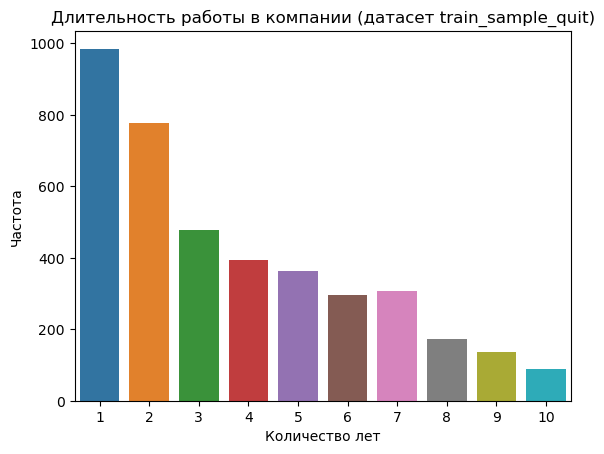

In [71]:
sns.countplot(data=train_sample_quit, 
             x='employment_years')
plt.title('Длительность работы в компании (датасет train_sample_quit)')
plt.xlabel('Количество лет')
plt.ylabel('Частота')
plt.show()

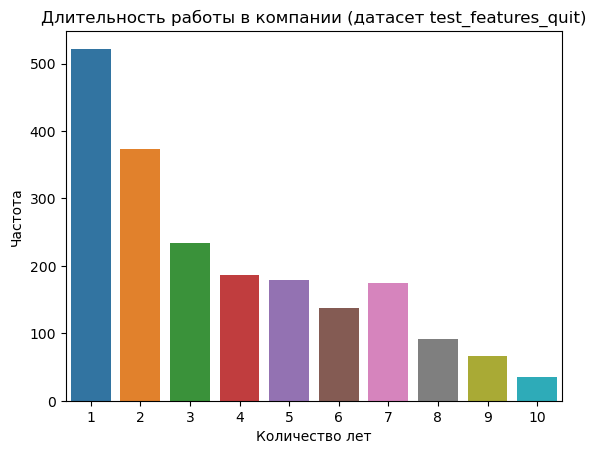

In [72]:
sns.countplot(data=test_features_quit, 
             x='employment_years')
plt.title('Длительность работы в компании (датасет test_features_quit)')
plt.xlabel('Количество лет')
plt.ylabel('Частота')
plt.show()

In [73]:
print('-'*25, 'Датасет train_sample_quit', '-'*25, '\n')
print(train_sample['employment_years'].value_counts())

print('\n', '-'*25, 'Датасет test_features', '-'*25, '\n')
print(test_features['employment_years'].value_counts())

------------------------- Датасет train_sample_quit ------------------------- 

employment_years
1     852
2     718
3     458
4     372
5     371
7     291
6     282
8     191
9     129
10     91
Name: count, dtype: int64

 ------------------------- Датасет test_features ------------------------- 

employment_years
1     522
2     374
3     234
4     187
5     179
7     174
6     138
8      91
9      66
10     35
Name: count, dtype: int64


Данные этих датасетов полностью повторяют данные из датасетов в задаче 1

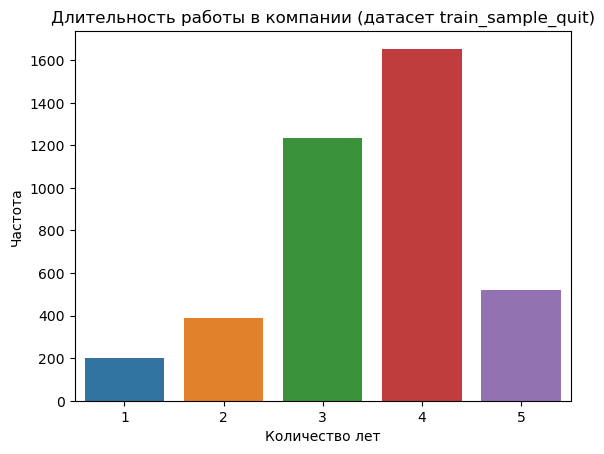

In [74]:
sns.countplot(data=train_sample_quit, 
             x='supervisor_evaluation')
plt.title('Длительность работы в компании (датасет train_sample_quit)')
plt.xlabel('Количество лет')
plt.ylabel('Частота')
plt.show()

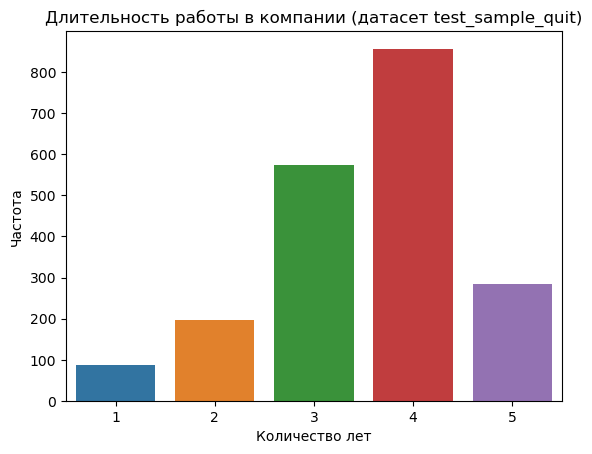

In [75]:
sns.countplot(data=test_features_quit, 
             x='supervisor_evaluation')
plt.title('Длительность работы в компании (датасет test_sample_quit)')
plt.xlabel('Количество лет')
plt.ylabel('Частота')
plt.show()

In [76]:
print('-'*25, 'Датасет train_sample_quit', '-'*25, '\n')
print(train_sample_quit['supervisor_evaluation'].value_counts())

print('\n', '-'*25, 'Датасет test_features_quit', '-'*25, '\n')
print(test_features_quit['supervisor_evaluation'].value_counts())

------------------------- Датасет train_sample_quit ------------------------- 

supervisor_evaluation
4    1654
3    1233
5     520
2     391
1     202
Name: count, dtype: int64

 ------------------------- Датасет test_features_quit ------------------------- 

supervisor_evaluation
4    857
3    575
5    284
2    196
1     88
Name: count, dtype: int64


Данные этих датасетов полностью повторяют данные из датасетов в задаче 1

------------------------- Датасет train_sample_quit ------------------------- 

Описательная статистика: salary


count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

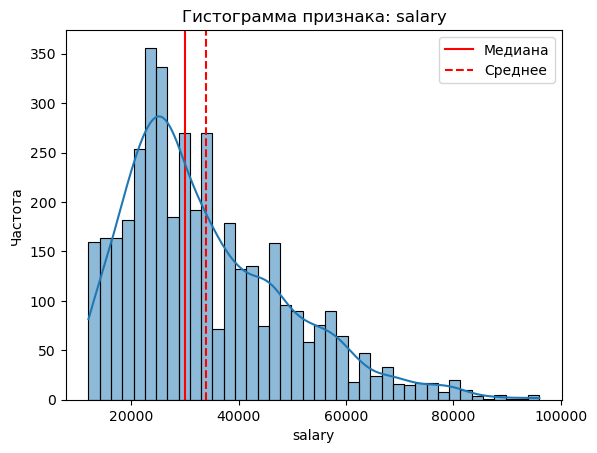

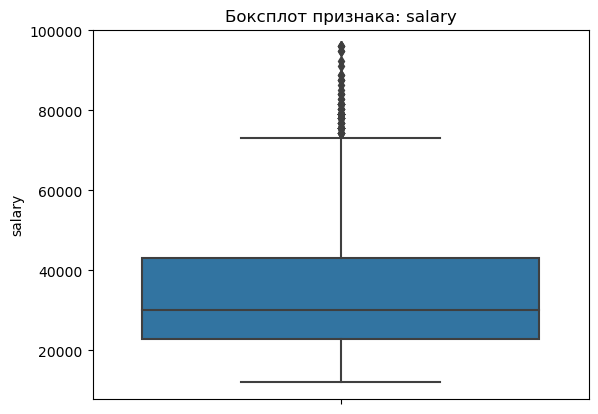


 ------------------------- Датасет test_features_quit ------------------------- 

Описательная статистика: salary


count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

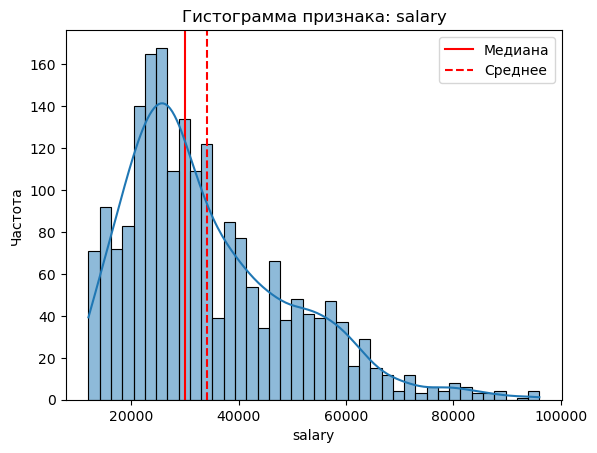

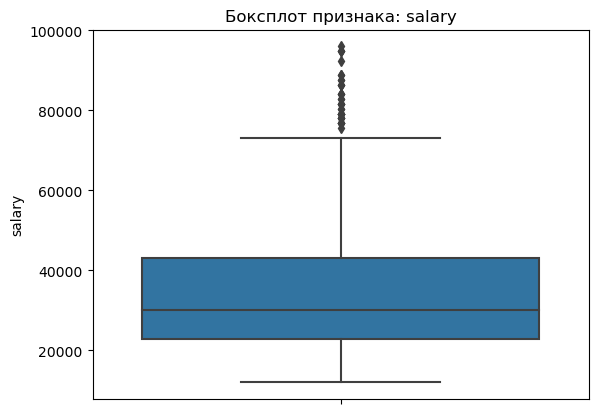

In [77]:
print('-'*25, 'Датасет train_sample_quit', '-'*25, '\n')

plt.axvline(x=train_sample_quit['salary'].median(), 
            c='red', 
            label='Медиана')

plt.axvline(x=train_sample_quit['salary'].mean(), 
            c='red', 
            linestyle='dashed', 
            label='Среднее')
plt.legend()
do_EDA(dataset=train_sample_quit, feature='salary', bins=40)

print('\n', '-'*25, 'Датасет test_features_quit', '-'*25, '\n')

plt.axvline(x=test_features_quit['salary'].median(), 
            c='red', 
            label='Медиана')

plt.axvline(x=test_features_quit['salary'].mean(), 
            c='red', 
            linestyle='dashed', 
            label='Среднее')
plt.legend()

do_EDA(dataset=test_features_quit, feature='salary', bins=40)

Данные этих датасетов полностью повторяют данные из датасетов в задаче 1

## Категориальные признаки 

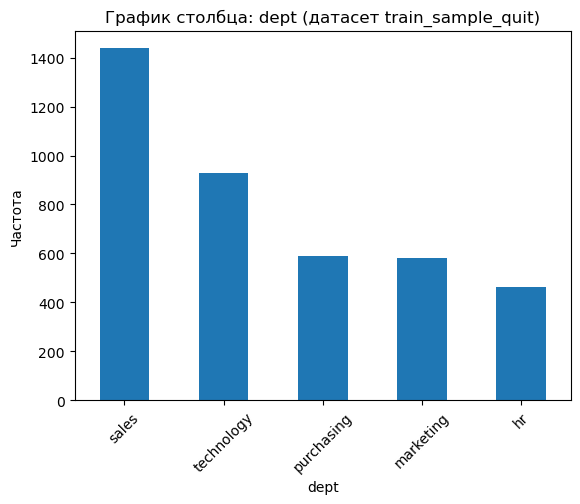

dept
sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: count, dtype: int64


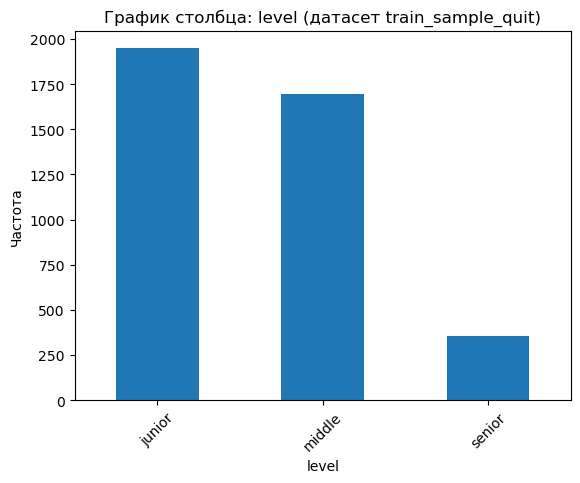

level
junior    1949
middle    1694
senior     357
Name: count, dtype: int64


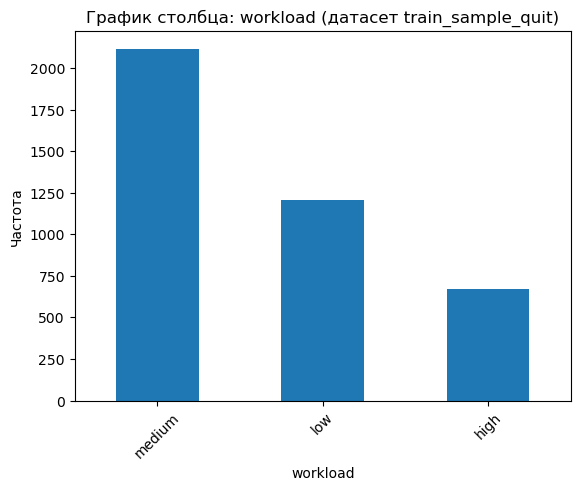

workload
medium    2118
low       1208
high       674
Name: count, dtype: int64


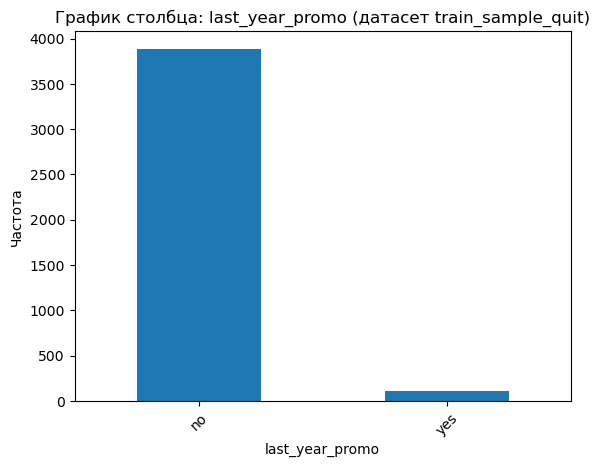

last_year_promo
no     3887
yes     113
Name: count, dtype: int64


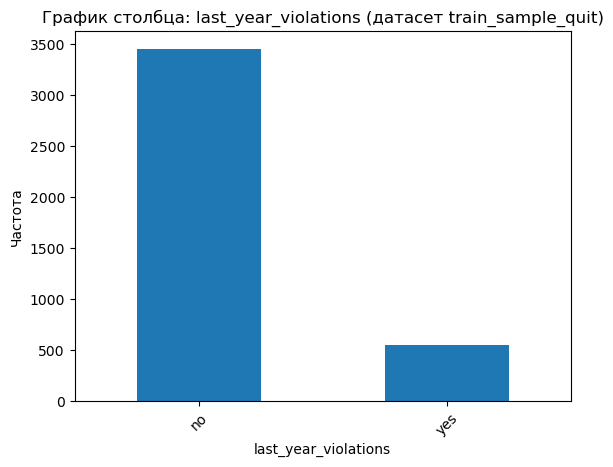

last_year_violations
no     3455
yes     545
Name: count, dtype: int64


In [78]:
for col in col_category: 
    train_sample_quit[col].value_counts().plot.bar()
    plt.title('График столбца: ' + col + ' (датасет train_sample_quit)')
    plt.ylabel('Частота')
    plt.xticks(rotation=45)
    plt.show()
    
    print(train_sample_quit[col].value_counts())

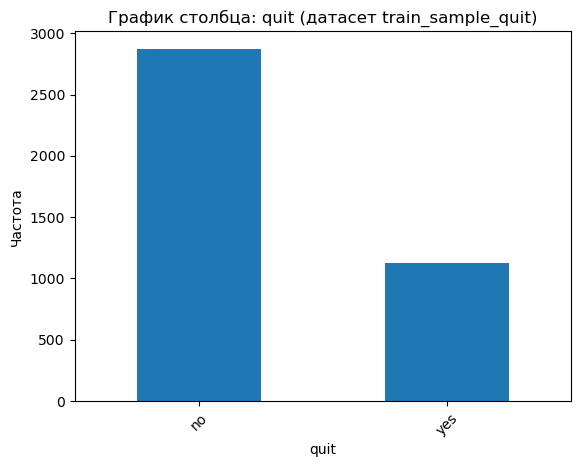

quit
no     2872
yes    1128
Name: count, dtype: int64


In [79]:
train_sample_quit['quit'].value_counts().plot.bar()
plt.title('График столбца: quit (датасет train_sample_quit)')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.show()
    
print(train_sample_quit['quit'].value_counts())

Данные этих датасетов полностью повторяют данные из датасетов в задаче 1. Людей, которые не уволились, подавляющее количесво

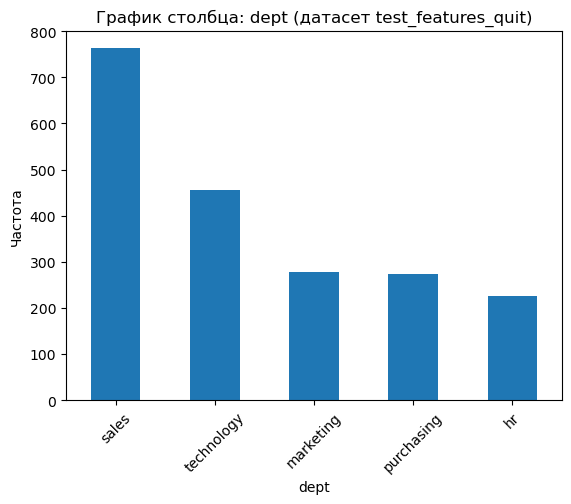

dept
sales         763
technology    455
marketing     279
purchasing    273
hr            227
Name: count, dtype: int64


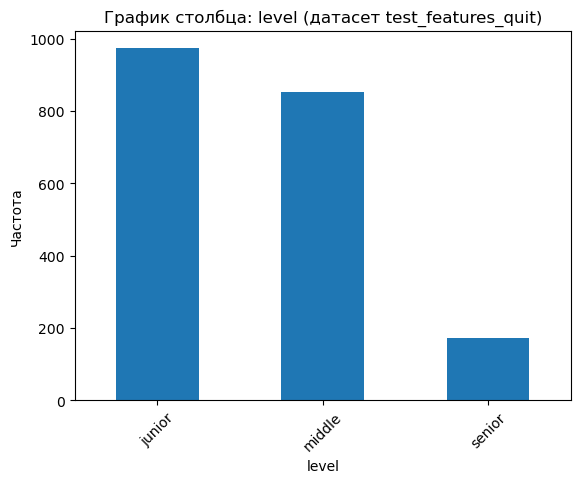

level
junior    974
middle    854
senior    171
Name: count, dtype: int64


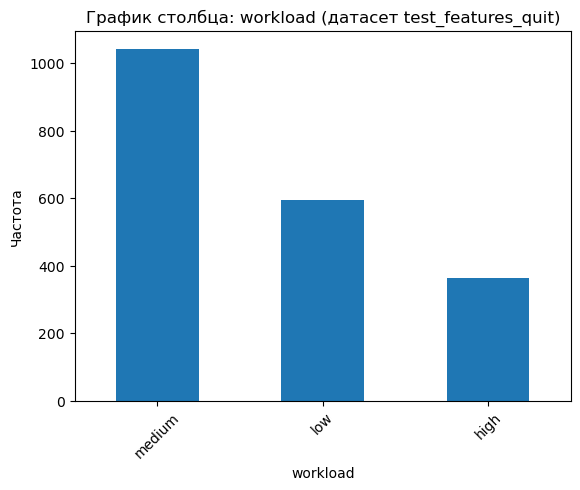

workload
medium    1043
low        593
high       363
Name: count, dtype: int64


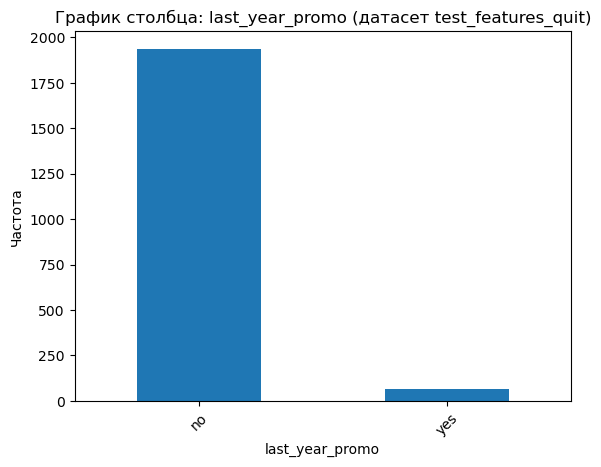

last_year_promo
no     1937
yes      63
Name: count, dtype: int64


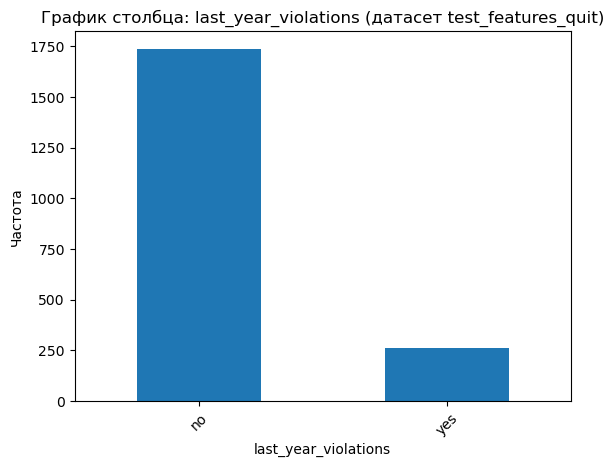

last_year_violations
no     1738
yes     262
Name: count, dtype: int64


In [80]:
for col in col_category: 
    
    test_features_quit[col].value_counts().plot.bar()
    plt.title('График столбца: ' + col + ' (датасет test_features_quit)')
    plt.ylabel('Частота')
    plt.xticks(rotation=45)
    plt.show()
    
    print(test_features_quit[col].value_counts())

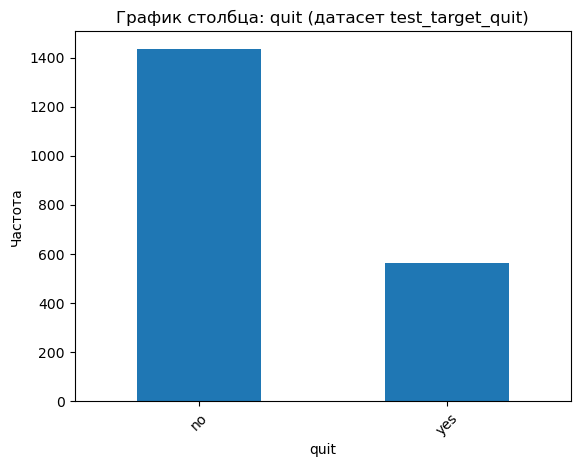

quit
no     1436
yes     564
Name: count, dtype: int64


In [81]:
test_target_quit['quit'].value_counts().plot.bar()
plt.title('График столбца: quit (датасет test_target_quit)')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.show()
    
print(test_target_quit['quit'].value_counts())

Данные этих датасетов полностью повторяют данные из датасетов в задаче 1. Людей, которые не уволились, подавляющее количесво

## Портрет уволившегося сотрудника 

Составим портрет по датасету `train_sample_quit`

In [82]:
retired_employee = train_sample_quit.query('quit == "yes"')
retired_employee.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
5,699916,sales,junior,low,1,no,yes,3,18000,yes
9,613206,technology,middle,medium,2,no,no,3,45600,yes
24,468145,technology,junior,medium,2,no,no,3,30000,yes
25,982346,marketing,junior,medium,3,no,no,3,30000,yes


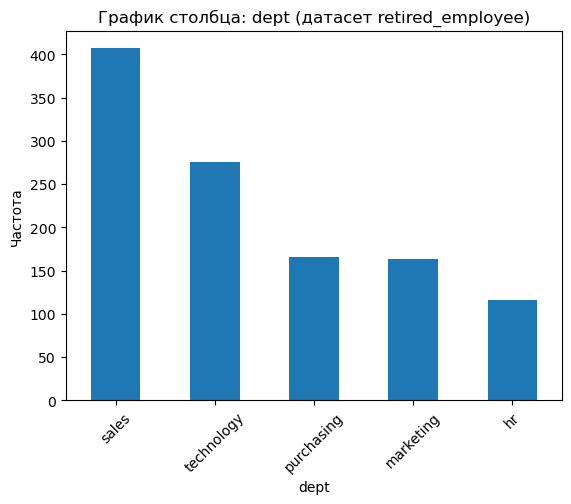

dept
sales         407
technology    276
purchasing    166
marketing     163
hr            116
Name: count, dtype: int64


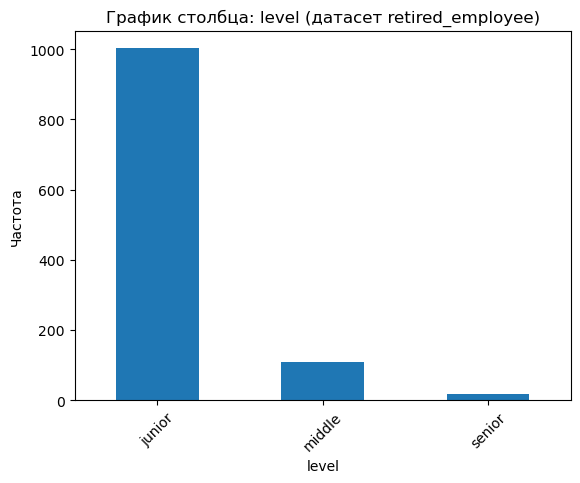

level
junior    1003
middle     108
senior      17
Name: count, dtype: int64


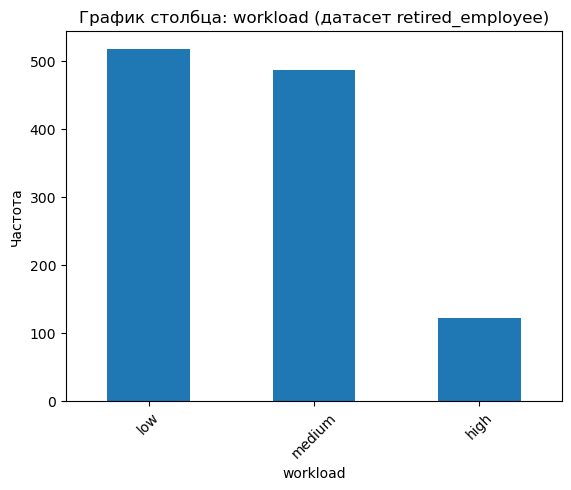

workload
low       519
medium    488
high      121
Name: count, dtype: int64


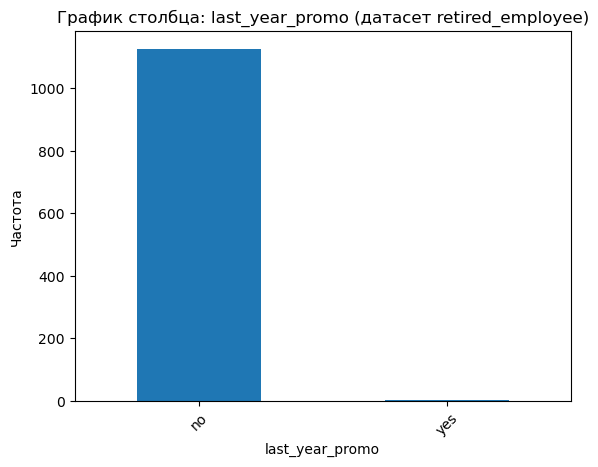

last_year_promo
no     1127
yes       1
Name: count, dtype: int64


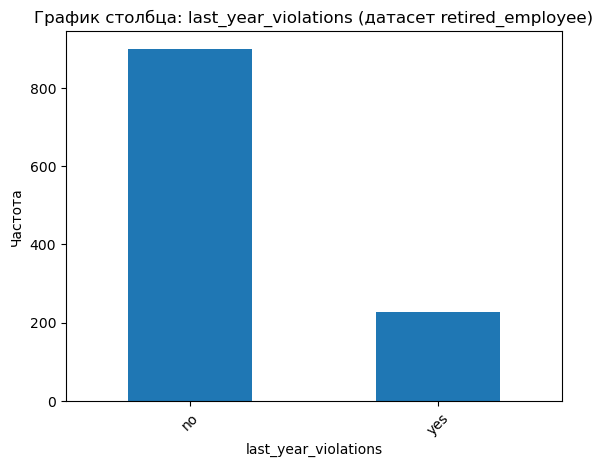

last_year_violations
no     900
yes    228
Name: count, dtype: int64


In [83]:
for col in col_category: 
    retired_employee[col].value_counts().plot.bar()
    plt.title('График столбца: ' + col + ' (датасет retired_employee)')
    plt.ylabel('Частота')
    plt.xticks(rotation=45)
    plt.show()
    
    print(retired_employee[col].value_counts())

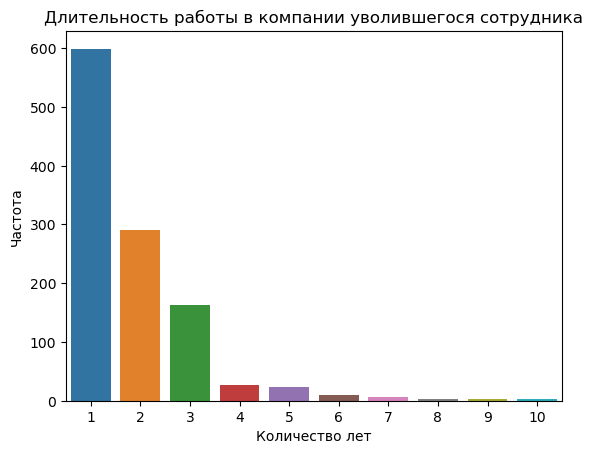

employment_years
1     599
2     290
3     163
4      27
5      23
6      10
7       7
10      3
8       3
9       3
Name: count, dtype: int64


In [84]:
sns.countplot(data=retired_employee, 
             x='employment_years')
plt.title('Длительность работы в компании уволившегося сотрудника')
plt.xlabel('Количество лет')
plt.ylabel('Частота')
plt.show()

print(retired_employee['employment_years'].value_counts())

In [85]:
data_not_quit = train_sample_quit.query('quit == "no"')

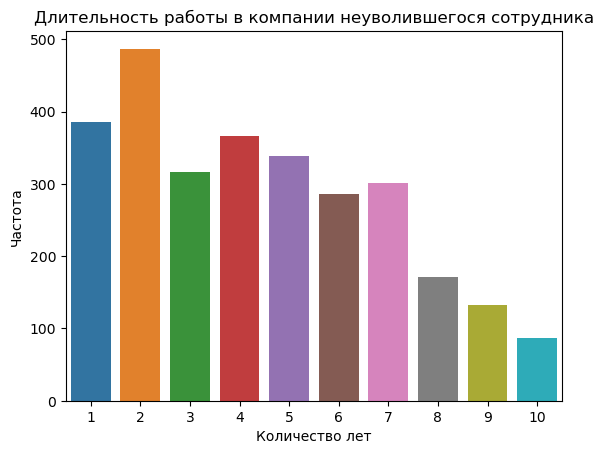

employment_years
2     487
1     386
4     366
5     339
3     316
7     301
6     286
8     171
9     133
10     87
Name: count, dtype: int64


In [86]:
sns.countplot(data=data_not_quit, 
             x='employment_years')
plt.title('Длительность работы в компании неуволившегося сотрудника')
plt.xlabel('Количество лет')
plt.ylabel('Частота')
plt.show()

print(data_not_quit['employment_years'].value_counts())

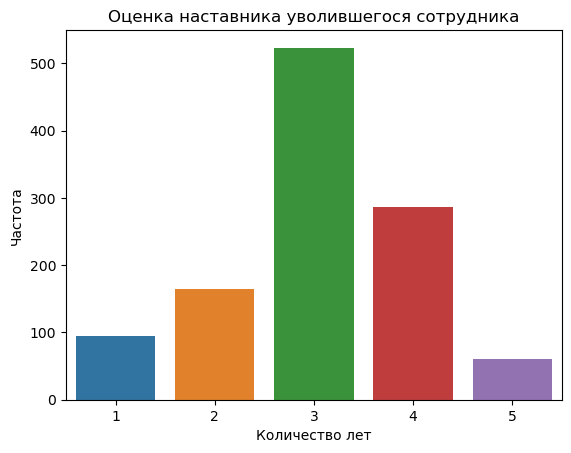

supervisor_evaluation
3    523
4    286
2    164
1     95
5     60
Name: count, dtype: int64


In [87]:
sns.countplot(data=retired_employee, 
             x='supervisor_evaluation')
plt.title('Оценка наставника уволившегося сотрудника')
plt.xlabel('Количество лет')
plt.ylabel('Частота')
plt.show()

print(retired_employee['supervisor_evaluation'].value_counts())

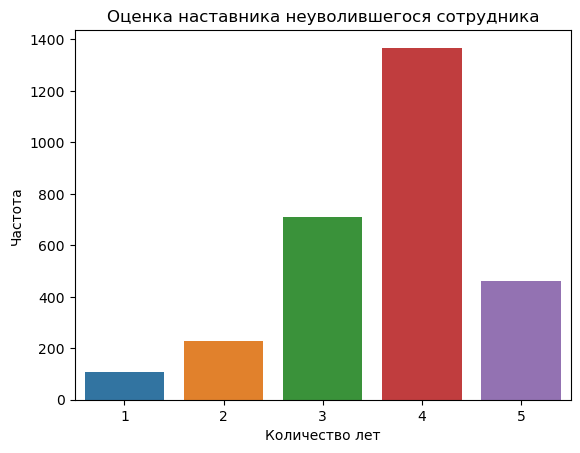

supervisor_evaluation
4    1368
3     710
5     460
2     227
1     107
Name: count, dtype: int64


In [88]:
sns.countplot(data=data_not_quit, 
             x='supervisor_evaluation')
plt.title('Оценка наставника неуволившегося сотрудника')
plt.xlabel('Количество лет')
plt.ylabel('Частота')
plt.show()

print(data_not_quit['supervisor_evaluation'].value_counts())

In [89]:
mean_1 = train_sample_quit[train_sample_quit['quit'] == 'yes']['salary'].mean()
print(f'Средняя зарплата уволившегося сотрудника {mean_1}')

mean_2 = train_sample_quit[train_sample_quit['quit'] == 'no']['salary'].mean()
print(f'Средняя зарплата уволившегося сотрудника {mean_2}')

Средняя зарплата уволившегося сотрудника 23885.106382978724
Средняя зарплата уволившегося сотрудника 37702.22841225627


Теперь можно узнать портрет уволившегося сотрудника: 
- Работает в отделе продаж
- Имеет уровень `junior`
- Имеет низкую или среднюю загруженность
- Не имел за последний год повышений
- Не имел за последний год нарушений трудового договора
- Проработал в компании год, в то время как неуволившиеся сотрудники имеют почти равномерное распределение
- Имеет оценку 3 от наставника (это меньше, если сравнивать с неуволившимися)
- Средняя зарплата уволившегося сотрудника значительно ниже (23885 против 37702)

##  Связь между `job_satisfaction_rate` и `quit`

В данном случае необходимо сравнить целевые признаки датасетов задачи 1 и задачи 2. Используем данные с обоими целевыми признаками тестовой выборки.

In [90]:
print(test_target.shape)
test_target.sort_values(by='id').head()

(2000, 2)


,id,job_satisfaction_rate
1734,100298,0.80
1467,100480,0.84
190,100503,0.79
60,100610,0.75
231,100692,0.69


In [91]:
print(test_target_quit.shape)
test_target_quit.sort_values(by='id').head()

(2000, 2)


,id,quit
1566,100298,no
491,100480,no
802,100503,no
725,100610,no
319,100692,no


Объединим данные по `id`

In [92]:
data_expl = test_target.merge(test_target_quit, on='id', how='left')
print(data_expl.shape)
data_expl.head()

(2000, 3)


,id,job_satisfaction_rate,quit
0,130604,0.74,no
1,825977,0.75,no
2,418490,0.60,yes
3,555320,0.72,no
4,826430,0.08,yes


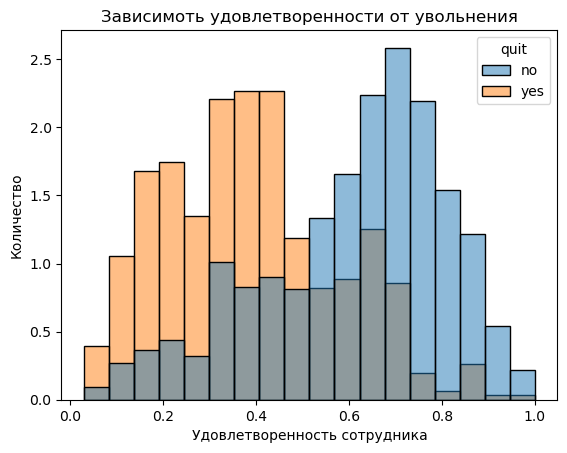

In [93]:
sns.histplot(data=data_expl, 
             x='job_satisfaction_rate', 
             hue='quit', 
             common_norm=False, 
             stat='density'
            )
plt.title('Зависимоть удовлетворенности от увольнения')
plt.xlabel('Удовлетворенность сотрудника')
plt.ylabel('Количество')
plt.show()

Исходя из графика, можно сделать вывод, что сотрудники с большой удовлетворенностью чаще всего не увлольняются

# Корреляционный анализ 

Проведем корреляционный анализ двух выборок

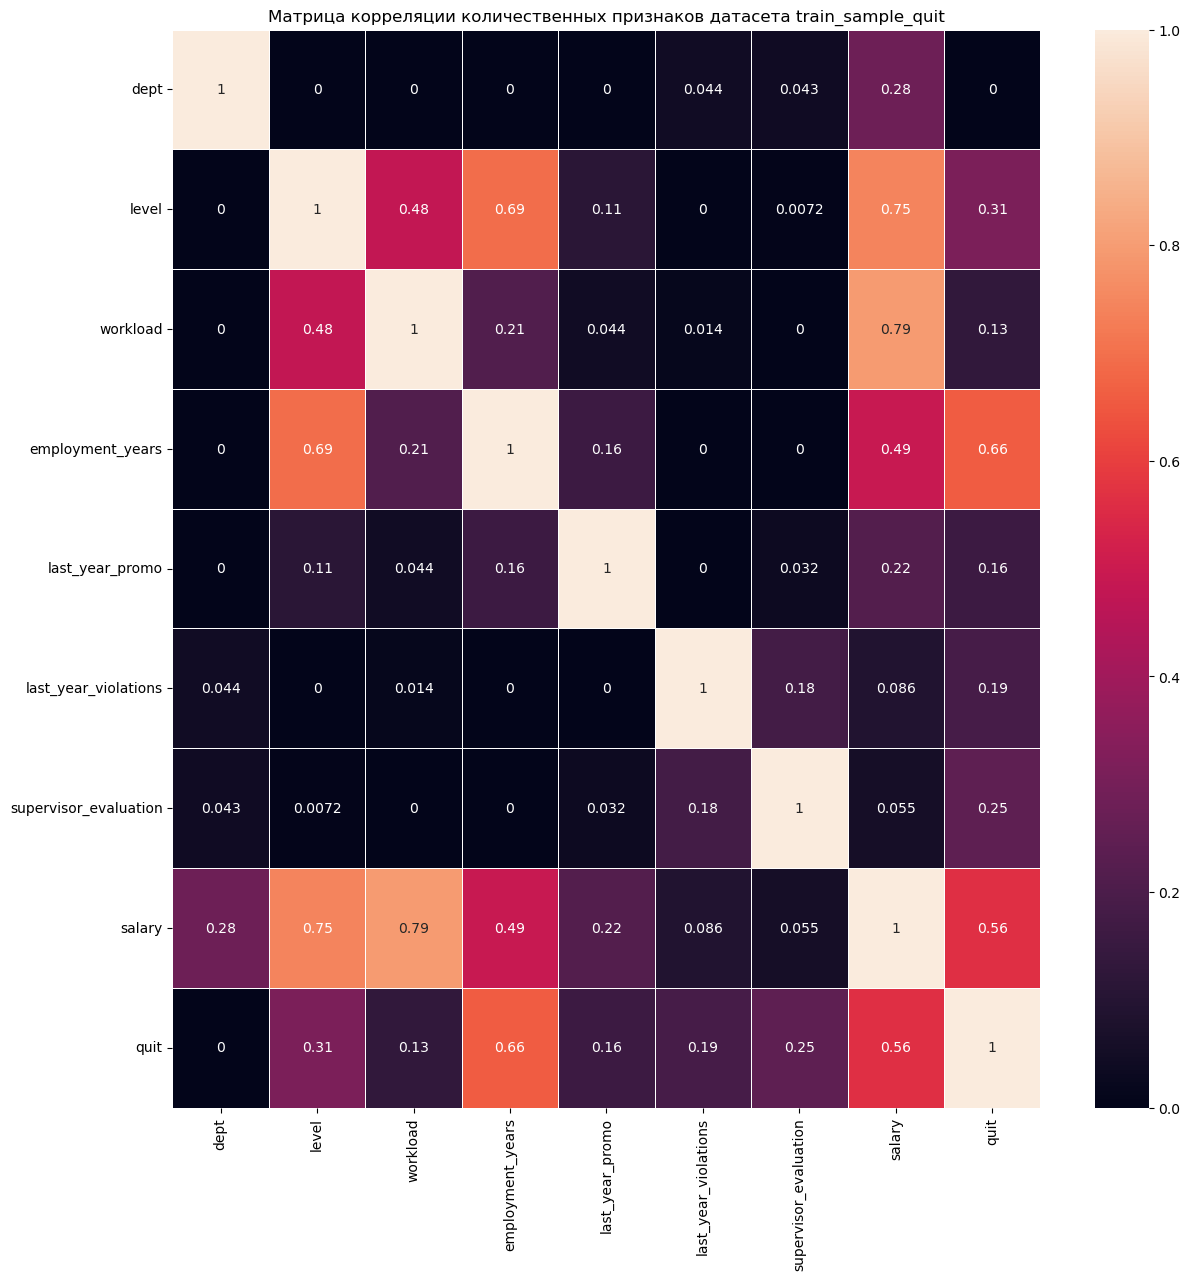

In [94]:
data_corr = train_sample_quit.drop('id', axis=1)

corr_matrix = data_corr.phik_matrix(interval_cols = [
                                                     'salary', 
                                                     'job_satisfaction_rate', 
                                                     ])

plt.figure(figsize= (14,14))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5)
plt.title('Матрица корреляции количественных признаков датасета train_sample_quit')
plt.show()

In [95]:
data_for_corr_ = test_features_quit.merge(test_target_quit, on='id', how='left')
data_for_corr_.shape

(2000, 10)

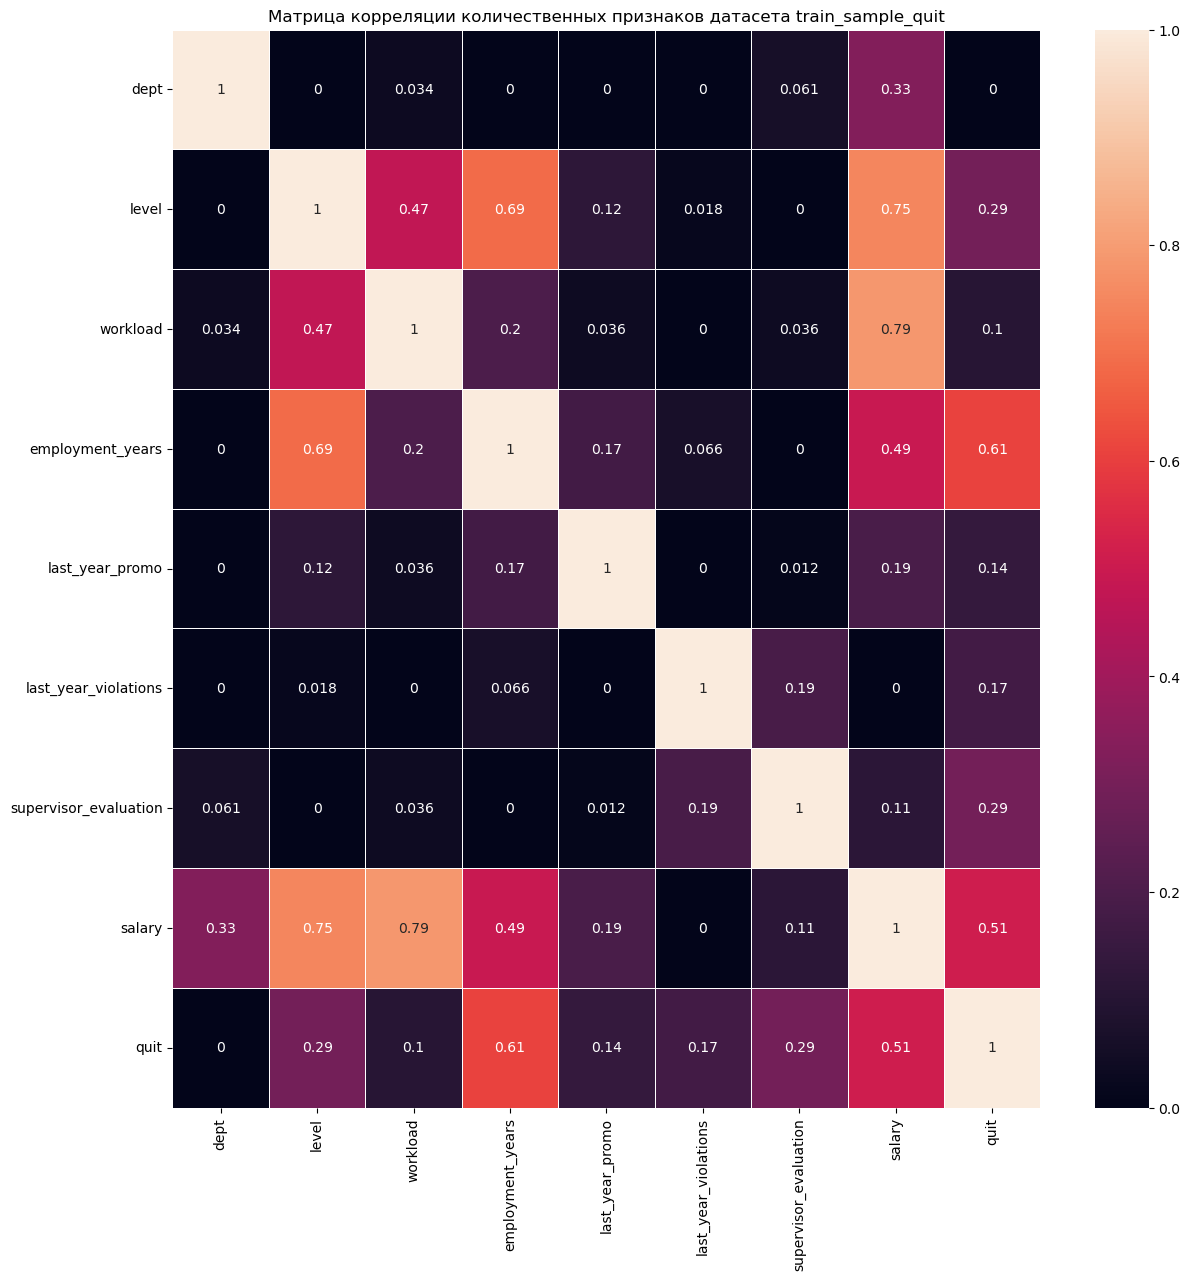

In [96]:
data_corr = data_for_corr_.drop('id', axis=1)

corr_matrix = data_corr.phik_matrix(interval_cols = [
                                                     'salary', 
                                                     'job_satisfaction_rate', 
                                                     ])

plt.figure(figsize= (14,14))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5)
plt.title('Матрица корреляции количественных признаков датасета train_sample_quit')
plt.show()

**Вывод**: Сильной линейной взаимосвязи между признаками не наблюдается. Мультиколлинеарности нет

# Добавление признаков

С помощью наилучшей модели, полученной в задаче 1, добавим `job_satisfaction_rate` к входным признакам второй задачи. 

In [97]:
test_features_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [98]:
X_train_quit = train_sample_quit.drop(['id', 'quit'], axis=1)

X_test_quit = test_features_quit.drop('id', axis=1)

In [99]:
X_train_quit_transformed = pipe_final.named_steps['preprocessor'].transform(X_train_quit)

X_test_quit_transformed = pipe_final.named_steps['preprocessor'].transform(X_test_quit)

In [100]:
train_sample_quit['job_satisfaction_rate'] = best_model.predict(X_train_quit_transformed)

test_features_quit['job_satisfaction_rate'] = best_model.predict(X_test_quit_transformed)

Проверим добавленные признаки

In [101]:
train_sample_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.604091
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.811966
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.398806
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.338333
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.811966


In [102]:
test_features_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.811966
1,686555,hr,junior,medium,1,no,no,4,30000,0.657826
2,467458,sales,middle,low,5,no,no,4,19200,0.697778
3,418655,sales,middle,low,6,no,no,4,19200,0.697778
4,789145,hr,middle,medium,5,no,no,5,40800,0.807978


Новый признак успешно добавлен к исходным датасетам

# Подготовка данных

Подготовим признаки аналогично первой задаче, дополнив пайплайн

In [103]:
test_features_quit.shape 

(2000, 10)

In [104]:
test_target_quit.shape

(2000, 2)

In [105]:
test_sample_quit = test_features_quit.merge(test_target_quit, on='id', how='left')
print(test_sample_quit.shape)
test_sample_quit.head()

(2000, 11)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.811966,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.657826,no
2,467458,sales,middle,low,5,no,no,4,19200,0.697778,no
3,418655,sales,middle,low,6,no,no,4,19200,0.697778,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.807978,no


Проверим наличие явных дубликатов после удаления столбца `id`. Если они будут, то удалим их

In [106]:
train_sample_quit.drop('id', axis=1).duplicated().sum()

1413

In [107]:
train_sample_quit = train_sample_quit.drop('id', axis=1).drop_duplicates()
train_sample_quit.duplicated().sum()

0

Явные дубликаты успешно удалены

In [108]:
# Сэмплирование
X_train_quit = train_sample_quit.drop('quit', axis=1)
y_train_quit = train_sample_quit['quit']
X_test_quit = test_sample_quit.drop('quit', axis=1)
y_test_quit = test_sample_quit['quit']

In [109]:
# Кодирование целевого признака
le = LabelEncoder()
y_train_quit = le.fit_transform(y_train_quit)
y_test_quit = le.transform(y_test_quit)

le.classes_

array(['no', 'yes'], dtype=object)

In [110]:
# Столбцы для кодирования 
ohe_cols = ['dept']

ord_cols = ['level', 
            'workload', 
            'last_year_promo', 
            'last_year_violations']

num_cols = ['employment_years', 
            'supervisor_evaluation', 
            'salary', 
            'job_satisfaction_rate']

In [111]:
data_preprocessor.fit_transform(X_train_quit)

array([[ 0.        ,  0.        ,  1.        , ...,  0.58517219,
         1.03861836,  0.60409091],
       [ 0.        ,  0.        ,  1.        , ...,  0.58517219,
        -0.58457755,  0.81196629],
       [ 0.        ,  1.        ,  0.        , ..., -2.19251672,
         0.00567551,  0.39880597],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.58517219,
         0.30080204,  0.60826087],
       [ 0.        ,  1.        ,  0.        , ...,  0.58517219,
        -1.54373877,  0.5175    ],
       [ 0.        ,  1.        ,  0.        , ...,  0.58517219,
        -0.21566939,  0.49107143]])

# Обучение моделей 

In [112]:
# Подбор скейлеров и моделей
param_grid_quit = [
    {
    'models' : [SVC(random_state=RANDOM_STATE, probability=True)],
    'models__C' : np.arange(0.1, 2, 0.2),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), "passthrough"]  
    },
    {
     'models' : [KNeighborsClassifier()], 
     'models__n_neighbors': range(2, 5),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), "passthrough"]   
    },   
    {
    'models' : [DecisionTreeClassifier(random_state=RANDOM_STATE)],
    'models__max_depth': (range(2, 10)),
    'models__max_features': (range(2,10)),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), "passthrough"]
    },
]

In [113]:
# Запуск перебора скейлеров и моделей
grid_quit = GridSearchCV(
        pipe_final, 
        param_grid=param_grid_quit, 
        cv=5, 
        scoring= 'roc_auc', 
        n_jobs=-1)

In [114]:
grid_quit.fit(X_train_quit, y_train_quit)
print('Лучшая модель и ее параметры:\n \n', grid_quit.best_estimator_)

Лучшая модель и ее параметры:
 
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                          

In [115]:
print('Лучшие параметры модели:')
grid_quit.best_params_

Лучшие параметры модели:


{'models': DecisionTreeClassifier(random_state=1),
 'models__max_depth': 5,
 'models__max_features': 7,
 'preprocessor__num': StandardScaler()}

In [116]:
print(f'Наилучший показатель оценки качества ROC-AUC: {grid_quit.best_score_}')

Наилучший показатель оценки качества ROC-AUC: 0.9081696406799228


In [117]:
pd.DataFrame(grid_quit.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__C,param_preprocessor__num,param_models__n_neighbors,param_models__max_depth,param_models__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.662389,0.141032,0.202461,0.008202,"SVC(probability=True, random_state=1)",0.1,StandardScaler(),NaN,NaN,NaN,"{'models': SVC(probability=True, random_state=1), 'models__C': 0.1, 'preprocessor__num': StandardScaler()}",0.905705,0.890145,0.883598,0.889330,0.915249,0.896805,0.011782,52
1,1.792926,0.151099,0.198262,0.026722,"SVC(probability=True, random_state=1)",0.1,MinMaxScaler(),NaN,NaN,NaN,"{'models': SVC(probability=True, random_state=1), 'models__C': 0.1, 'preprocessor__num': MinMaxScaler()}",0.900779,0.893935,0.883400,0.880051,0.913939,0.894421,0.012244,65
2,2.337941,0.087973,0.257945,0.022658,"SVC(probability=True, random_state=1)",0.1,passthrough,NaN,NaN,NaN,"{'models': SVC(probability=True, random_state=1), 'models__C': 0.1, 'preprocessor__num': 'passthrough'}",0.800528,0.715346,0.744057,0.744849,0.728981,0.746752,0.029000,229
3,1.718506,0.103167,0.169372,0.010279,"SVC(probability=True, random_state=1)",0.3,StandardScaler(),NaN,NaN,NaN,"{'models': SVC(probability=True, random_state=1), 'models__C': 0.30000000000000004, 'preprocessor__num': StandardScaler()}",0.909552,0.894083,0.886169,0.887402,0.920041,0.899449,0.013239,28
4,1.694851,0.047465,0.166105,0.019516,"SVC(probability=True, random_state=1)",0.3,MinMaxScaler(),NaN,NaN,NaN,"{'models': SVC(probability=True, random_state=1), 'models__C': 0.30000000000000004, 'preprocessor__num': MinMaxScaler()}",0.906981,0.897282,0.886149,0.881377,0.921076,0.898573,0.014345,38
5,2.893447,0.326602,0.243142,0.032457,"SVC(probability=True, random_state=1)",0.3,passthrough,NaN,NaN,NaN,"{'models': SVC(probability=True, random_state=1), 'models__C': 0.30000000000000004, 'preprocessor__num': 'passthrough'}",0.800548,0.716437,0.745976,0.744587,0.731937,0.747897,0.028394,227
6,1.879681,0.247322,0.165619,0.039965,"SVC(probability=True, random_state=1)",0.5,StandardScaler(),NaN,NaN,NaN,"{'models': SVC(probability=True, random_state=1), 'models__C': 0.5000000000000001, 'preprocessor__num': StandardScaler()}",0.910494,0.891255,0.887731,0.889852,0.919767,0.899820,0.012890,19
7,1.736018,0.265339,0.156398,0.018455,"SVC(probability=True, random_state=1)",0.5,MinMaxScaler(),NaN,NaN,NaN,"{'models': SVC(probability=True, random_state=1), 'models__C': 0.5000000000000001, 'preprocessor__num': MinMaxScaler()}",0.905568,0.895156,0.885872,0.880352,0.920717,0.897533,0.014414,43
8,2.389646,0.192465,0.221871,0.020314,"SVC(probability=True, random_state=1)",0.5,passthrough,NaN,NaN,NaN,"{'models': SVC(probability=True, random_state=1), 'models__C': 0.5000000000000001, 'preprocessor__num': 'passthrough'}",0.800253,0.716178,0.748032,0.749930,0.725138,0.747906,0.029221,226
9,1.480722,0.135496,0.142201,0.016932,"SVC(probability=True, random_state=1)",0.7,StandardScaler(),NaN,NaN,NaN,"{'models': SVC(probability=True, random_state=1), 'models__C': 0.7000000000000001, 'preprocessor__num': StandardScaler()}",0.911220,0.890275,0.887948,0.889611,0.919302,0.899671,0.013005,24


In [118]:
X_test_quit_transformed = pipe_final.named_steps['preprocessor'].transform(X_test_quit)

best_model_quit = grid_quit.best_estimator_.named_steps['models']

predictions = best_model_quit.predict(X_test_quit_transformed)

roc_auc_test = roc_auc_score(y_test_quit, best_model_quit.predict_proba(X_test_quit_transformed)[:, 1])

print(f'Метрика ROC AUC на тестовой выборке {roc_auc_test}')

Метрика ROC AUC на тестовой выборке 0.9120327841324405


Оценка качества на тестовой выборке совпала с тренировочной

In [119]:
X_train_quit_transformed = data_preprocessor.fit_transform(X_train_quit)

dc = DummyClassifier(strategy="most_frequent")

dc.fit(X_train_quit_transformed, y_train_quit)

predictions_dummy = dc.predict(X_test_quit_transformed)

print(f'Оценка качества на "глупой" модели: {roc_auc_score(y_test_quit, dc.predict_proba(X_test_quit_transformed)[:, 1])}')

Оценка качества на "глупой" модели: 0.5


Глупая модель показала себя намного хуже

#  Промежуточный вывод

В задаче 2 была поставлена задача классификации, в которой перебиралось несколько моделей: `SVC`, `KNeighborsClassifier`, `DecisionTreeClassifier`. В результате наилучшей моделью оказалась `DecisionTreeClassifier` со следующими параметрами: 

In [120]:
grid_quit.best_params_

{'models': DecisionTreeClassifier(random_state=1),
 'models__max_depth': 5,
 'models__max_features': 7,
 'preprocessor__num': StandardScaler()}

Данная модель оказалась лучшей, так как `DecisionTreeClassifier` отлично подходит для данных с большим количеством катеориальных признаков

# Общий вывод 

В данном отчете были представлены 2 задачи, в которые входило: 
- предсказание уровня удовлетворенности сотрудников
- предсказание увольнения сотрудника

В результате чего была проделана следующая работа для обоих задач: 
1. Выгружены данные и проведено ознакомление с ними
2. Предобработка данных (были выделены некорректные значения и обнаружены пропуски)
3. Проведен исследовательский анализ данных для количественных и категориальных значений. Во второй задаче был составлен портрет уволившегося сотрудника
4. Подготовка данных с помощью составления пайплайна 
5. Обучено несколько моделей, подобраны наилучшие кодировщики и модели
6. Был составлен промежуточный вывод по работе наилучшей модели

Исходя из результатов исследования можно составить рекомендации для бизнеса: 
1. Основной отдел, в котором наблюдается утечка кадров - отдел продаж. Стоит продумать варианты поддержки сотрудников этого отдела (введение социальных льгот, улучшение премиальной системы)
2. Большинство уволившихся сотрудников имеет низкую загруженность по работе. Следует ввести/улучшить систему таймменеджмента и более рационально распределять время на работу для сотрудников
3. Также большинство уволившихся сотрудников имеет уровень `junior`. Скорее всего новоиспеченным сотрудникам не хватает качественного и своевременного менторства для своей работы. Следует модернизировать систему обучения и внедрения сотрудников в работу компании